# Time series prediction

### In this kernel different approaches for time series prediction implemented including:

- Moving average and random walk as baseline.
- Simple Exponential Smoothing (SES), Double Exponential Smoothing (Holt), and Tripple Exponential Smoothing (Holt's winter)
- ARMA, ARIMA, and SARIMA
- Deep learning approaches:
>- Univariate:
>>- Multilayer Perceptron (MLP)
>>- Convolutional Neural Network (CNN)
>>- LSTM Models: Vanilla LSTM, Stacked LSTM, Bidirectional LSTM, CNN LSTM and, ConvLSTM
>- Multivariate:
>>- Multiple Input series with Stacked LSTM
>>- Multiple Parallel Series



In [ ]:
import pandas as pd
from sklearn.metrics import  mean_squared_error
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from scipy.stats import spearmanr,pearsonr
import numpy as np

In [107]:
file_path = r''
df = pd.read_csv(file_path )

In [108]:
df.head()

,<TICKER>,<DTYYYYMMDD>,<FIRST>,<HIGH>,<LOW>,<CLOSE>,<VALUE>,<VOL>,<OPENINT>,<PER>,<OPEN>,<LAST>
0,S*Isfahan.Steel,20200817,8195.0,8450.0,8062.0,8136.0,2462156161815,302612530,43274,D,8486.0,8350.0
1,S*Isfahan.Steel,20200816,8485.0,8595.0,8485.0,8486.0,896064983676,105588807,13542,D,8931.0,8485.0
2,S*Isfahan.Steel,20200815,8927.0,9070.0,8927.0,8931.0,591015110544,66177404,11094,D,9396.0,8927.0
3,S*Isfahan.Steel,20200812,9830.0,10070.0,9157.0,9396.0,1844173966745,196270575,27996,D,9638.0,9157.0
4,S*Isfahan.Steel,20200811,9638.0,9638.0,9638.0,9638.0,502094424296,52095292,10380,D,10145.0,9638.0


In [109]:
df.drop(['<TICKER>', '<VALUE>', '<PER>'], axis =1, inplace=True)

In [110]:
cols = ['Date', 'First', 'High', 'Low', 'Close', 'Volumn','Num_trans', 'Open','Last']
df.columns = cols

In [111]:
df.Date = df.Date.astype(str)

In [112]:
df.Date = pd.to_datetime(df.Date)

In [113]:
df['Day'] = df.Date.dt.day_name()
df['week'] = df.Date.dt.weekofyear
df['Month'] = df.Date.dt.month_name()
df['Year'] = df.Date.dt.year

In [122]:
df['ratio'] = df['Volumn']/df['Num_trans']
df['ratio'] = df['ratio']/10

In [123]:
df.sort_values('Date',inplace = True)

In [124]:
df.reset_index(inplace = True)

In [125]:
df.drop('index', inplace = True, axis = 1)

In [126]:
df['price'] = df.loc[:,['First','High','Low','Close','Last']].mean(axis = 1)

In [127]:
df2 = df.copy()

In [128]:
df2.set_index('Date', inplace = True) 


In [129]:
df2.tail()

,First,High,Low,Close,Volumn,Num_trans,Open,Last,Day,week,Month,Year,ratio,price
Date,,,,,,,,,,,,,,
2020-08-11,9638.0,9638.0,9638.0,9638.0,52095292,10380,10145.0,9638.0,Tuesday,33,August,2020,501.881426,9638.0
2020-08-12,9830.0,10070.0,9157.0,9396.0,196270575,27996,9638.0,9157.0,Wednesday,33,August,2020,701.066492,9522.0
2020-08-15,8927.0,9070.0,8927.0,8931.0,66177404,11094,9396.0,8927.0,Saturday,33,August,2020,596.515270,8956.4
2020-08-16,8485.0,8595.0,8485.0,8486.0,105588807,13542,8931.0,8485.0,Sunday,33,August,2020,779.713536,8507.2
2020-08-17,8195.0,8450.0,8062.0,8136.0,302612530,43274,8486.0,8350.0,Monday,34,August,2020,699.294103,8238.6


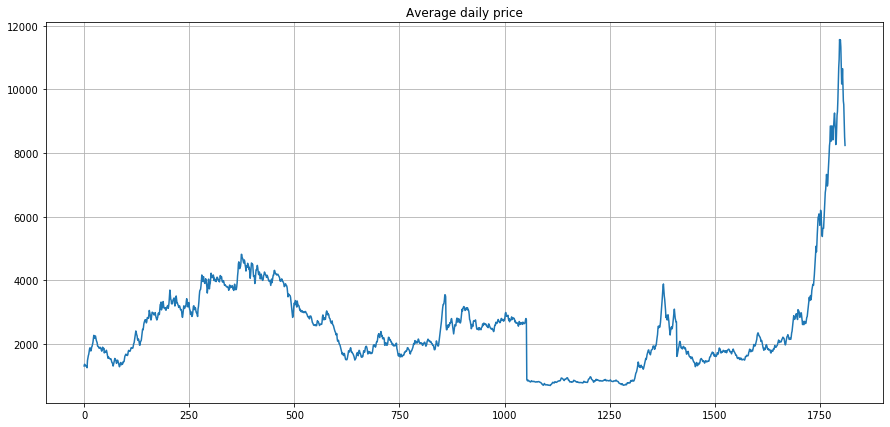

In [130]:
price = df.loc[:,['First','High','Low','Close','Last']].mean(axis = 1)
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(15, 7))
plt.plot(price)
plt.title('Average daily price')
plt.grid(True)
plt.show()

count     1811.000000
mean      2495.172170
std       1515.342578
min        690.000000
25%       1640.300000
50%       2148.800000
75%       3016.300000
max      11566.000000
dtype: float64


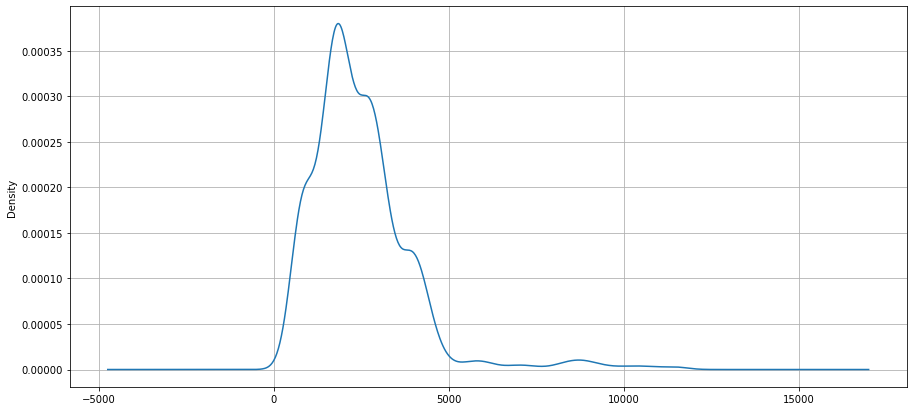

In [131]:
price.plot(kind = 'kde', figsize= (15,7), grid = True )
print(price.describe())

## Functions used:

In [33]:
##function to prepare test and train
def split(data, days_ahead):
    if type(data) is not list:
        data = list(data)
    size = int(len(data)-days_ahead)
    train,test = data[:size], data[size:]
    return train,test

# A simple plot function to compare predicted and actual price 
def plot_func(test, Pred, method):    
    with plt.style.context('seaborn-white'):
        plt.figure(figsize=(15, 7))
        plt.title("Predicted vs Price \n method = {}".format(method))
        plt.plot(test, label = "Actual")
        plt.plot(Pred, label = "Predicted")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.grid(True)
        

def Moving_average_evaluate(data, window):
    if type(data) is not(list):
        data = list(data)
    train,test = split(data, days_ahead)
    history =train
    predictions = []
    for t in range(len(test)):
        length = len(history)
        yhat = np.mean([history[i] for i in range(length-window,length)])
        obs = test[t]
        predictions.append(yhat)
        history.append(obs)
    return predictions, test     

# difference function
def difference(data, interval):
	diff = list()
	for i in range(interval, len(data)):
		value = data[i] - data[i - interval]
		diff.append(value)
	return diff

# inverse-difference function
def inverse_difference(diff, data):
    inverted = []
    for i in range(len(diff)):
        inverted.append(diff[i]+ data[i])
    return(inverted) 

###Exponential smoothing Holt 
def EXP_II_evaluate(data):
    if type(data) is not(list):
        data = list(data)
    train,test = split(data, days_ahead)
    history =train
    predictions = []
    for t in range(len(test)):
        model = ExponentialSmoothing(history,trend = 'mul', damped= True)
        model_fit = model.fit(optimized  = True)
        yhat = model_fit.forecast()
        obs = test[t]
        predictions.append(yhat)
        history.append(obs)
    return predictions, test,model_fit 

### Exponential smoothing Holt-Winter
def EXP_III_evaluate(data):
    if type(data) is not(list):
        data = list(data)
    train,test = split(data, days_ahead)
    history =train
    predictions = []
    for t in range(len(test)):
        model = ExponentialSmoothing(history,trend = 'mul', damped= True, seasonal="add", seasonal_periods=100)
        model_fit = model.fit(optimized  = True)
        yhat = model_fit.forecast()
        obs = test[t]
        predictions.append(yhat)
        history.append(obs)
    return predictions, test,model_fit  


## ARIMA
def ARIMA_evaluate(data, order):
    """
    order = (p,d,q)
    p: lag order
    d: difference order
    q: moving average order for error
    """
    if type(data) is not(list):
        data = list(data)
    train,test = split(data, days_ahead)   
    history =train
    predictions = []
    for t in range(len(test)):
        model = ARIMA(history, order= order)
        model_fit = model.fit()
        yhat = model_fit.forecast()
        obs = test[t]
        predictions.append(yhat)
        history.append(obs)
    return predictions, test,model_fit  

def plot_func_ARIMA (test, Pred, method,order):    
    with plt.style.context('seaborn-white'):
        plt.figure(figsize=(15, 7))
        plt.title("Predicted vs Price \n method = {} with order= {} ".format(method,order))
        plt.plot(test, label = "Actual")
        plt.plot(Pred, label = "Predicted")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.grid(True)
        
        

        
        

## SARIMA
def SARIMA_evaluate(data, order, seasonal_order):
    """
    order = (p,d,q)
    p: lag order
    d: difference order
    q: moving average order for error
    seasonal_order = (P,D,Q,m)
    
    """
    if type(data) is not(list):
        data = list(data)
    train,test = split(data, days_ahead)   
    history =train
    predictions = []
    for t in range(len(test)):
        model = ARIMA(history, order= order, seasonal_order=seasonal_order) 
        model_fit = model.fit()
        yhat = model_fit.forecast()
        obs = test[t]
        predictions.append(yhat)
        history.append(obs)
    return predictions, test,model_fit  

def plot_func_SARIMA (test, Pred, method,order, seasonal_order):    
    with plt.style.context('seaborn-white'):
        plt.figure(figsize=(15, 7))
        plt.title("Predicted vs Price \n method = {} with order= {} and seasonol_order {} ".format(method,order, seasonal_order))
        plt.plot(test, label = "Actual")
        plt.plot(Pred, label = "Predicted")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.grid(True)        
        
       

#### Daily average price considered to predict the average price for the next day under univariate format.

#### Naive Approch: Random walk where the prediction for tomorrows's price is the previous day's price. This is considered as base prediction to see how others perform better compared eith random walk


tomorrow's price:  = 8507.2
Error:   186953.8857142857
Predicted:  10221.4   Actual:  10653.0
Predicted:  10653.0   Actual:  10145.2
Predicted:  10145.2   Actual:  9638.0
Predicted:  9638.0   Actual:  9522.0
Predicted:  9522.0   Actual:  8956.4
Predicted:  8956.4   Actual:  8507.2
Predicted:  8507.2   Actual:  8238.6


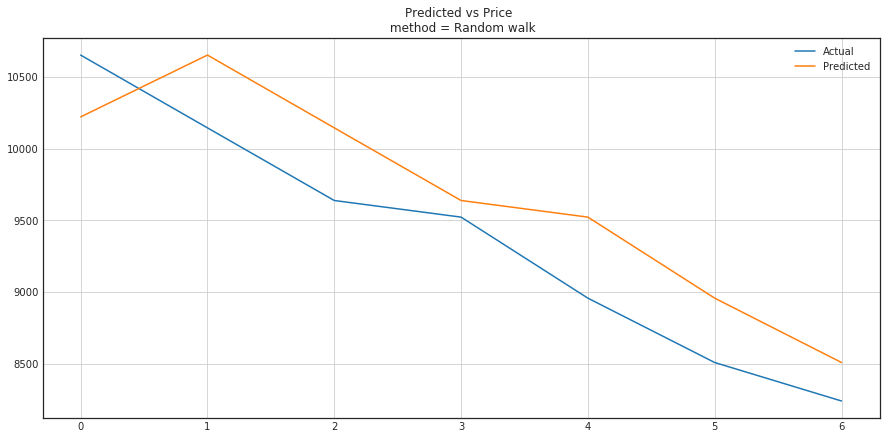

In [21]:
###prepare first Naive
data = price
days_ahead = 7
train,test= split(data, days_ahead)
predictions = []
for t in range(len(test)):
    obs = test[t]
    yhat = train[-1]
    train.append(obs)
    predictions.append(yhat)
print( "tomorrow's price:  =",  predictions[-1] ) 
error_NA = mean_squared_error(test, predictions)
print("Error:  ", error_NA)
for item in zip(predictions,test):
    print("Predicted: ", item[0], "  Actual: ", item[1]) 
predictions_NA = predictions
plot_func(test, predictions, method = "Random walk" )

### Moving Average: The prediction for tomorrow = average of lag varibales determined by window size.

tomorrow's price:  = 8995.2
Error:   426463.9441269838
Predicted: 10364.80   Actual:  10653.0
Predicted: 10347.80   Actual:  10145.2
Predicted: 10339.87   Actual:  9638.0
Predicted: 10145.40   Actual:  9522.0
Predicted: 9768.40   Actual:  8956.4
Predicted: 9372.13   Actual:  8507.2
Predicted: 8995.20   Actual:  8238.6


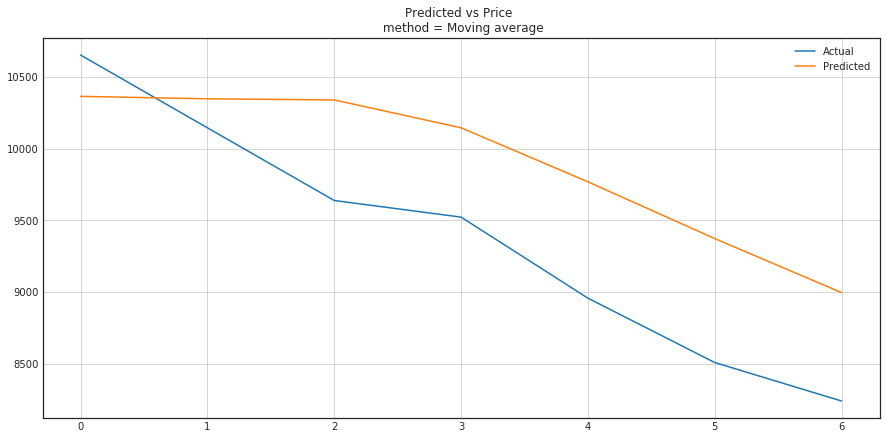

In [22]:
data = price
days_ahead = 7
window = 3
predictions, test  = Moving_average_evaluate(data, window)
print( "tomorrow's price:  =",  predictions[-1] ) 
error_MA = mean_squared_error(test, predictions)
print("Error:  ", error_MA)
for item in zip(predictions,test):
    print("Predicted:", '%.2f'%item[0], "  Actual: ", item[1]) 
predictions_MA = predictions
plot_func(test, predictions, method = "Moving average" )


### Checking the stationarity of average price:  AdFuller test can be used.   

In [23]:
result_adfuller = adfuller(price)
print("H0 for adfuller test is data non-stationary")
print('ADF Statistic: %f' % result_adfuller[0])
print('p-value: %f' % result_adfuller[1])
print('number of lags used in regression to determine t-statistic: %d' % result_adfuller[2] )
print('Number of observations used in the analysis: %d' % result_adfuller[3])
print('Critical Values:')
for key, value in result_adfuller[4].items():
	print('\t%s: %.3f' % (key, value))
if  result_adfuller[0] > max(list(result_adfuller[4].values())):
    print("H0 cannot be rejected so data is non-stationary and its statistics change over time")

H0 for adfuller test is data non-stationary
ADF Statistic: -0.449624
p-value: 0.901478
number of lags used in regression to determine t-statistic: 3
Number of observations used in the analysis: 1807
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568
H0 cannot be rejected so data is non-stationary and its statistics change over time


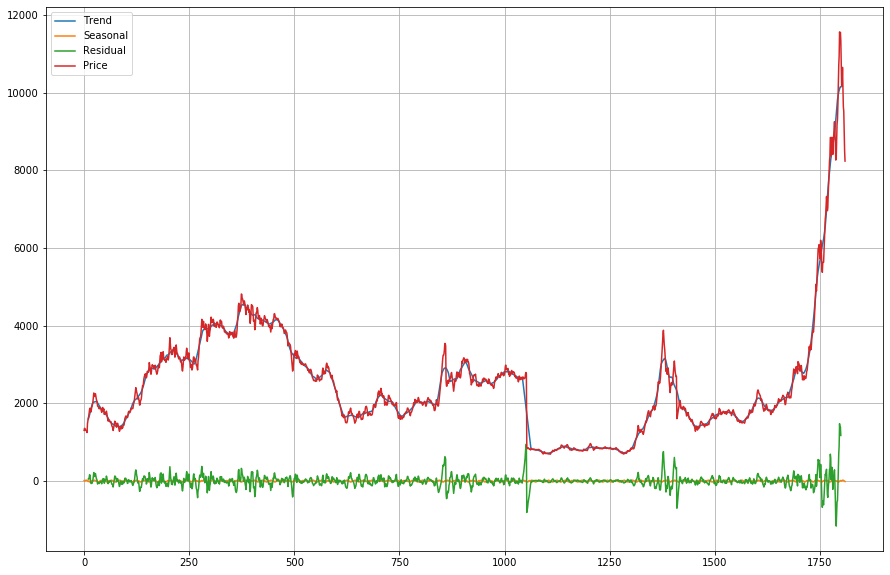

In [24]:
result_decompose = seasonal_decompose(price, model='add', period =20)

plt.figure(figsize=(15, 10))
plt.plot(result_decompose.trend, label = "Trend")
plt.plot(result_decompose.seasonal, label = "Seasonal")
plt.plot(result_decompose.resid,label = "Residual")
plt.plot(result_decompose.observed,  label = "Price")
plt.legend(loc="best")
plt.grid(True) 
plt.show()

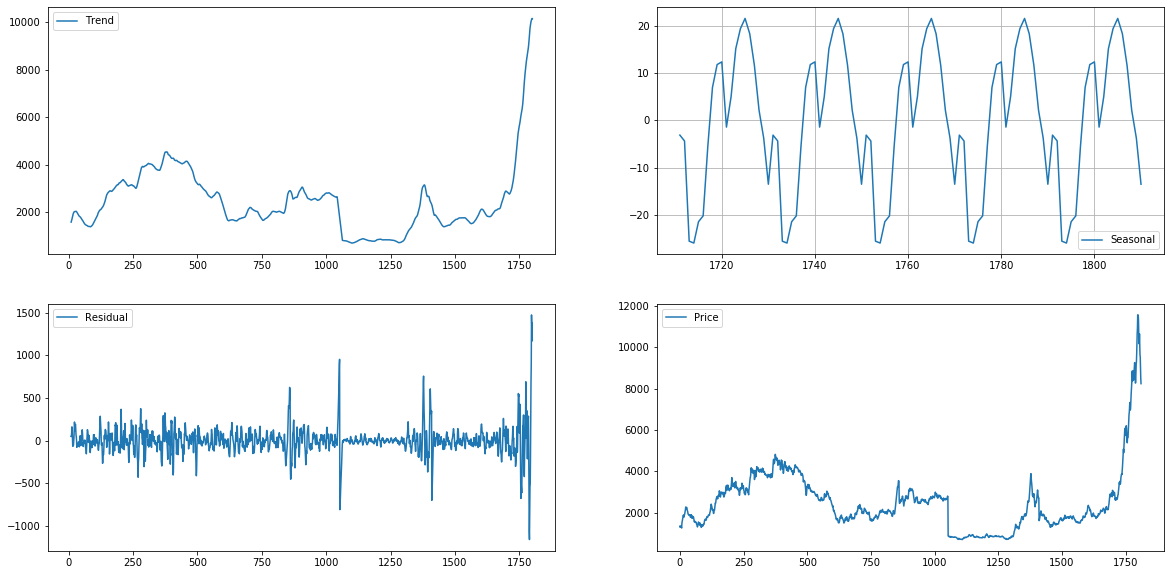

In [25]:
plt.figure(figsize=(20, 10))
plt.subplot(2, 2, 1)
plt.plot(result_decompose.trend, label = "Trend")
plt.legend(loc="best")
plt.subplot(2, 2, 2)
plt.plot(result_decompose.seasonal[-100:], label = "Seasonal")
plt.grid(True)
plt.legend(loc="best")
plt.subplot(2, 2, 3)
plt.plot(result_decompose.resid,label = "Residual")
plt.legend(loc="best")
plt.subplot(2, 2, 4)
plt.plot(result_decompose.observed,  label = "Price")
plt.legend(loc="best")

### Detrending data makes data stationary

In [26]:
price_diff = difference(price,interval=1)
result_diff = adfuller(price_diff)
print("H0 for adfuller test is data non-stationary")
print('ADF Statistic: %f' % result_diff[0])
print('p-value: %f' % result_diff[1])
print('number of lags used in regression to determine t-statistic: %d' % result_diff[2] )
print('Number of observations used in the analysis: %d' % result_diff[3])
print('Critical Values:')
for key, value in result_diff[4].items():
	print('\t%s: %.3f' % (key, value))
if  result_diff[0] > max(list(result_diff[4].values())):
    print("H0 cannot be rejected so data is non-stationary and its statistics change over time")
else:
    print("H0 is rejected hence data is stationary")

H0 for adfuller test is data non-stationary
ADF Statistic: -20.619296
p-value: 0.000000
number of lags used in regression to determine t-statistic: 2
Number of observations used in the analysis: 1807
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568
H0 is rejected hence data is stationary


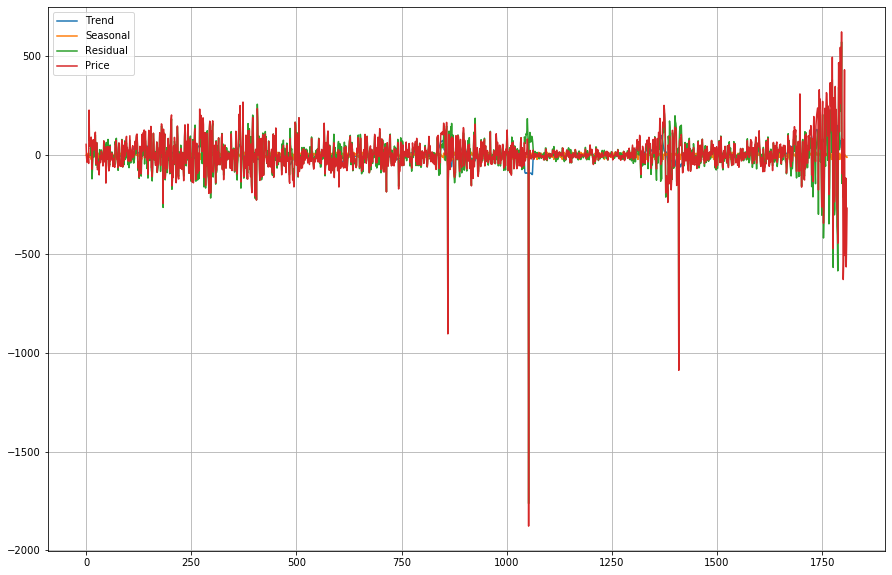

In [27]:
data = difference(price,interval = 1)
result_decompose = seasonal_decompose(data, model='add', period =20)

plt.figure(figsize=(15, 10))
plt.plot(result_decompose.trend, label = "Trend")
plt.plot(result_decompose.seasonal, label = "Seasonal")
plt.plot(result_decompose.resid,label = "Residual")
plt.plot(result_decompose.observed,  label = "Price")
plt.legend(loc="best")
plt.grid(True) 
plt.show()

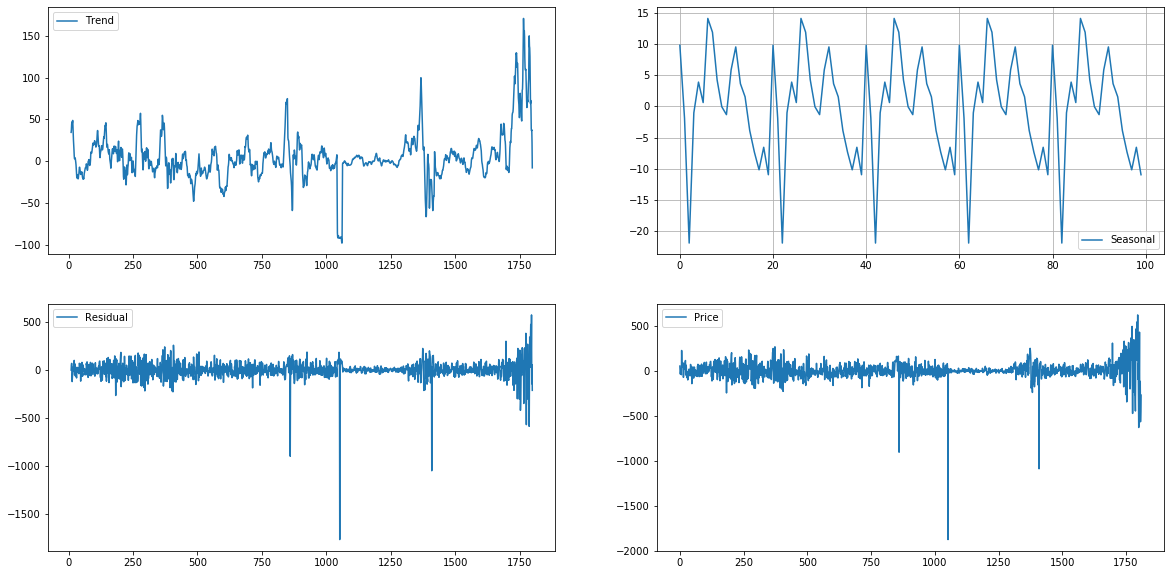

In [28]:
plt.figure(figsize=(20, 10))
plt.subplot(2, 2, 1)
plt.plot(result_decompose.trend, label = "Trend")
plt.legend(loc="best")
plt.subplot(2, 2, 2)
plt.plot(result_decompose.seasonal[-100:], label = "Seasonal")
plt.grid(True)
plt.legend(loc="best")
plt.subplot(2, 2, 3)
plt.plot(result_decompose.resid,label = "Residual")
plt.legend(loc="best")
plt.subplot(2, 2, 4)
plt.plot(result_decompose.observed,  label = "Price")
plt.legend(loc="best")

### Implementing Exponential Smoothing:
* Simple Exponential Smoothing (SES) or type I: a time series forecasting method for univariate data without a trend or seasonality. (Level)
* Double Exponential Smoothing or type II:  an extension to Exponential Smoothing that explicitly adds support for trends in the univariate time series.(level+ trend)
* Triple Exponential Smoothing or type III: Triple Exponential Smoothing is an extension of Exponential Smoothing that explicitly adds support for seasonality to the univariate time series.(level+trend+seasonality)

tomorrow's price:  = [8347.20432466]
Error:   155373.2900584634
Predicted: 10241.64   Actual:  10653.0
Predicted: 10824.68   Actual:  10145.2
Predicted: 9966.16   Actual:  9638.0
Predicted: 9453.91   Actual:  9522.0
Predicted: 9478.79   Actual:  8956.4
Predicted: 8751.53   Actual:  8507.2
Predicted: 8347.20   Actual:  8238.6
                       ExponentialSmoothing Model Results                       
Dep. Variable:                    endog   No. Observations:                 1810
Model:             ExponentialSmoothing   SSE                       17026596.657
Optimized:                         True   AIC                          16570.061
Trend:                   Multiplicative   BIC                          16597.567
Seasonal:                          None   AICC                         16570.123
Seasonal Periods:                  None   Date:                 Wed, 19 Aug 2020
Box-Cox:                          False   Time:                         16:57:04
Box-Cox Coeff.:          

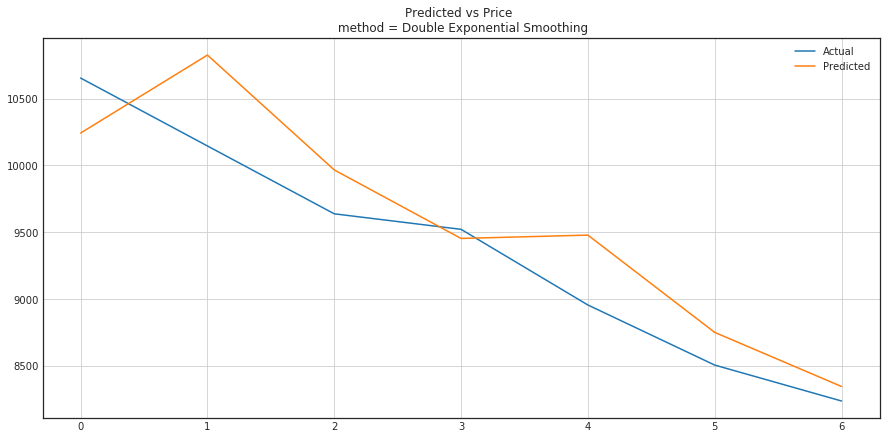

In [29]:
warnings.filterwarnings('ignore')
data = price
days_ahead = 7
predictions, test, model_fit  = EXP_II_evaluate(data)
print( "tomorrow's price:  =",  predictions[-1] ) 
error_EXP_II = mean_squared_error(test, predictions)
print("Error:  ", error_EXP_II)
for item in zip(predictions,test):
    print("Predicted:", '%.2f'%item[0], "  Actual: ", item[1]) 
predictions_EXP_II = predictions
plot_func(test, predictions, method = "Double Exponential Smoothing" )
print(model_fit.summary())

### Data has no obvious seasonality. Triple EXP is useful for data with seasonality
- As seen below Holt-Winter does not predict well.

tomorrow's price:  = [8382.48137941]
Error:   244369.274745068
Predicted: 10292.93   Actual:  10653.0
Predicted: 10713.21   Actual:  10145.2
Predicted: 10237.36   Actual:  9638.0
Predicted: 9695.62   Actual:  9522.0
Predicted: 9651.48   Actual:  8956.4
Predicted: 9111.41   Actual:  8507.2
Predicted: 8382.48   Actual:  8238.6


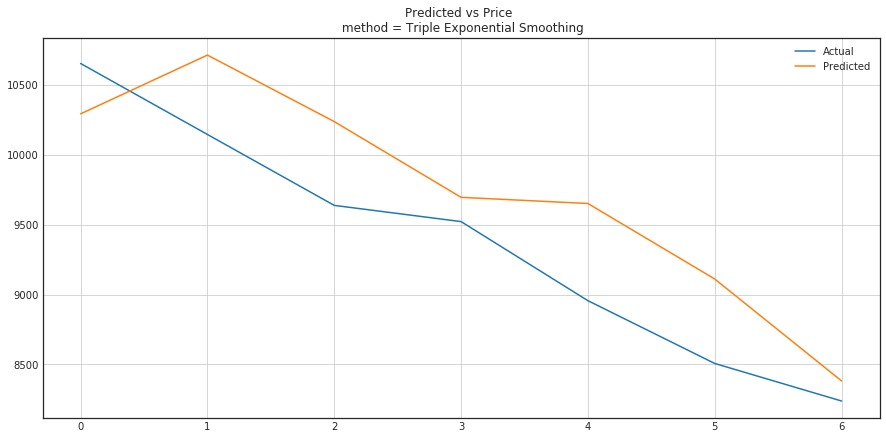

In [34]:
warnings.filterwarnings('ignore')
data = price
days_ahead = 7
predictions, test, model_fit  = EXP_III_evaluate(data)
print( "tomorrow's price:  =",  predictions[-1] ) 
error_EXP_III = mean_squared_error(test, predictions)
print("Error:  ", error_EXP_III)
for item in zip(predictions,test):
    print("Predicted:", '%.2f'%item[0], "  Actual: ", item[1]) 
predictions_EXP_III = predictions
plot_func(test, predictions, method = "Triple Exponential Smoothing" )


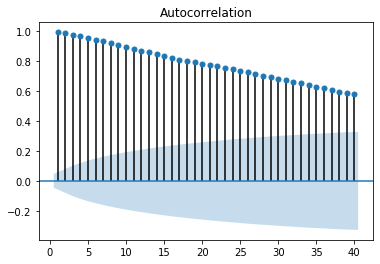

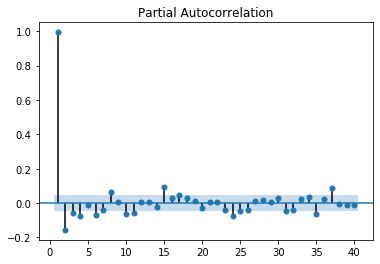

In [253]:
_ = plot_acf(price,zero = False, lags = 40)
_ = plot_pacf(price,zero = False, lags = 40)
# plt.show()

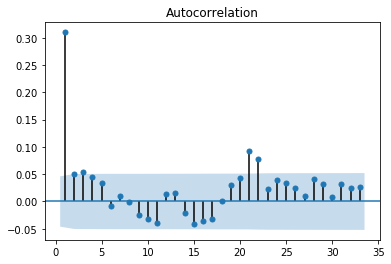

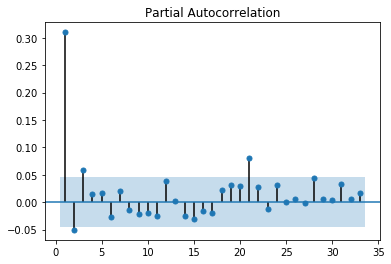

In [257]:
data = difference(price, interval = 1)
data = pd.Series(data)
_ = plot_acf(data,zero = False)
_ = plot_pacf(data,zero = False)

### with respect to the ACF and PACF plots:
- lag order from Partial autocorrelation plot: p = 3
- q = 1 from autocorrelation plot

### ARIMA:

tomorrow's price:  = [8384.5399826]
Error:   150531.4906665935
Predicted: 10247.55   Actual:  10653.0
Predicted: 10778.81   Actual:  10145.2
Predicted: 9953.55   Actual:  9638.0
Predicted: 9531.12   Actual:  9522.0
Predicted: 9509.93   Actual:  8956.4
Predicted: 8753.18   Actual:  8507.2
Predicted: 8384.54   Actual:  8238.6
ARIMA Model's configuration:
                                 SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1810
Model:                 ARIMA(3, 1, 1)   Log Likelihood              -10859.179
Date:                Tue, 18 Aug 2020   AIC                          21728.357
Time:                        11:16:19   BIC                          21755.860
Sample:                             0   HQIC                         21738.507
                               - 1810                                         
Covariance Type:                  opg                                         
           

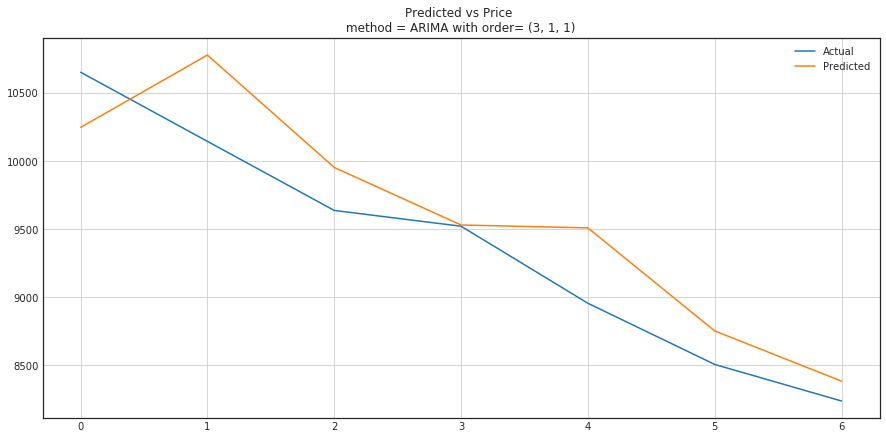

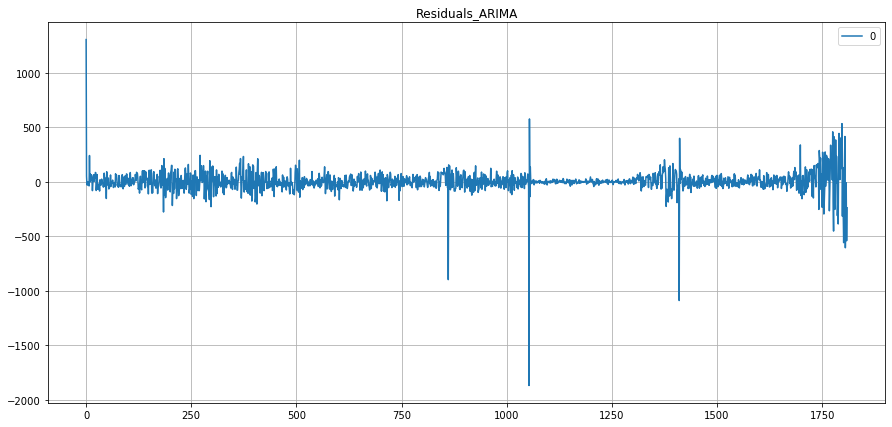

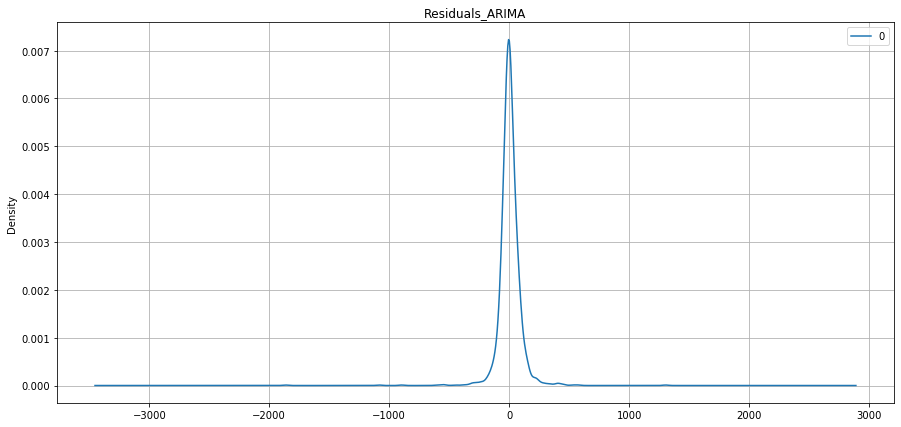

Residuals_ARIMA statistics:                   0
count  1810.000000
mean      3.274014
std     102.531657
min   -1867.287206
25%     -31.673206
50%       0.035131
75%      38.511285
max    1304.000000


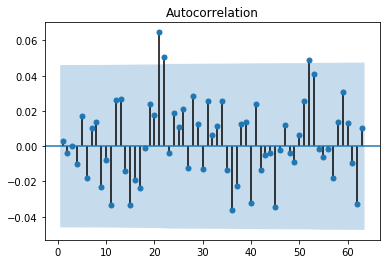

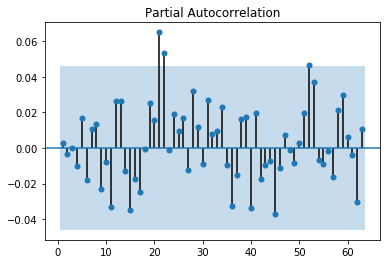

In [283]:
warnings.filterwarnings('ignore')
data = price
days_ahead = 7
order = (3,1,1) 
predictions, test, model_fit = ARIMA_evaluate(data, order)

print( "tomorrow's price:  =",  predictions[-1] ) 
error_ARIMA = mean_squared_error(test, predictions)
print("Error:  ", error_ARIMA)
for item in zip(predictions,test):
    print("Predicted:", '%.2f'%item[0], "  Actual: ", item[1]) 
predictions_ARIMA = predictions
plot_func_ARIMA (test, predictions, method = "ARIMA",order = order)

print("ARIMA Model's configuration:\n ", model_fit.summary())
residuals_ARIMA = pd.DataFrame(model_fit.resid)
residuals_ARIMA.plot(figsize= (15,7), grid = True)
plt.title("Residuals_ARIMA")
plt.show()
residuals_ARIMA.plot(kind='kde', figsize= (15,7), grid = True)
plt.title("Residuals_ARIMA")
plt.show()
print("Residuals_ARIMA statistics: ", residuals_ARIMA.describe())
_  = plot_acf(residuals_ARIMA,zero = False, lags = 63)
_ = plot_pacf(residuals_ARIMA,zero = False, lags = 63)

### SARIMA
* with respect to residuals ACF and PACF it is seen that 21th and 22th lags are significant in ACF and PACF this suggests P =2, Q = 2 with m=21. Consequently, I am trying SARIMA to see if it can do better than ARIMA

tomorrow's price:  = [8406.44626529]
Error:   148858.5615756609
Predicted: 10255.25   Actual:  10653.0
Predicted: 10794.38   Actual:  10145.2
Predicted: 9963.23   Actual:  9638.0
Predicted: 9511.71   Actual:  9522.0
Predicted: 9494.30   Actual:  8956.4
Predicted: 8704.62   Actual:  8507.2
Predicted: 8406.45   Actual:  8238.6
SARIMA Model's configuration:
                                         SARIMAX Results                                       
Dep. Variable:                                     y   No. Observations:                 1810
Model:             ARIMA(3, 1, 1)x(2, 1, [1, 2], 21)   Log Likelihood              -10765.986
Date:                               Tue, 18 Aug 2020   AIC                          21549.973
Time:                                       11:06:13   BIC                          21599.373
Sample:                                            0   HQIC                         21568.214
                                              - 1810                         

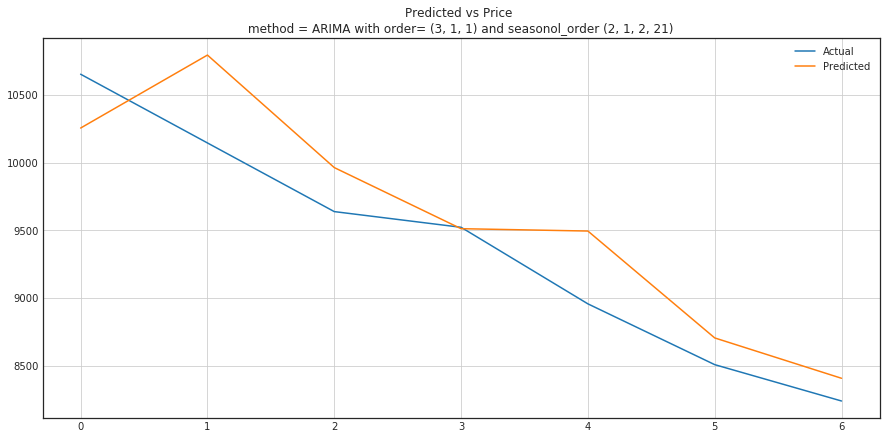

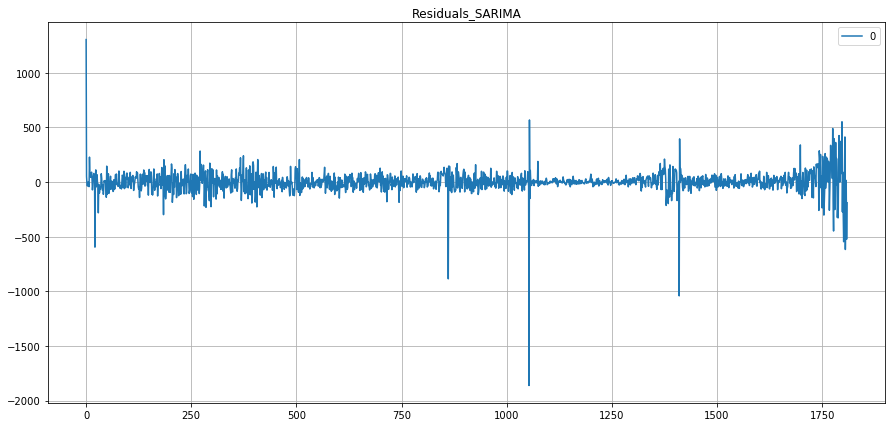

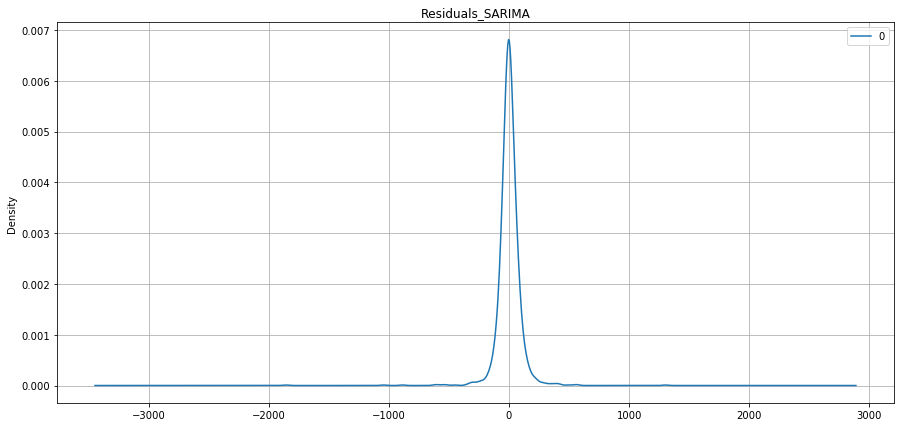

Residuals_SARIMA statistics:                   0
count  1810.000000
mean      1.001926
std     104.173498
min   -1862.400358
25%     -35.970294
50%      -0.087434
75%      38.837110
max    1304.000000


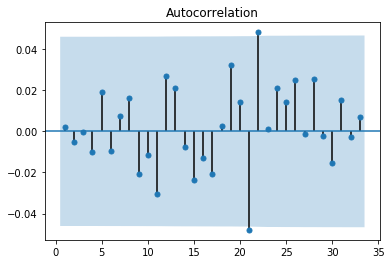

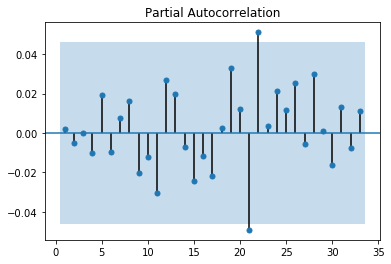

In [282]:
warnings.filterwarnings('ignore')
data = price
days_ahead = 7
order = (3,1,1) 
seasonal_order = (2,1,2,21)
predictions, test, model_fit = SARIMA_evaluate(data, order, seasonal_order)

print( "tomorrow's price:  =",  predictions[-1] ) 
error_SARIMA = mean_squared_error(test, predictions)
print("Error:  ", error_SARIMA)
for item in zip(predictions,test):
    print("Predicted:", '%.2f'%item[0], "  Actual: ", item[1]) 
predictions_SARIMA = predictions
plot_func_SARIMA (test, predictions, method = "ARIMA",order = order, seasonal_order = seasonal_order)


print("SARIMA Model's configuration:\n ", model_fit.summary())
residuals_SARIMA = pd.DataFrame(model_fit.resid)
residuals_SARIMA.plot(figsize= (15,7), grid = True)
plt.title("Residuals_SARIMA")
plt.show()
residuals_SARIMA.plot(kind='kde', figsize= (15,7), grid = True)
plt.title("Residuals_SARIMA")
plt.show()
print("Residuals_SARIMA statistics: ", residuals_SARIMA.describe())
_  = plot_acf(residuals_SARIMA,zero = False)
_ = plot_pacf(residuals_SARIMA,zero = False)

tomorrow's price:  = [8362.57987791]
Error:   145940.19253671434
Predicted: 10279.51   Actual:  10653.0
Predicted: 10782.91   Actual:  10145.2
Predicted: 9970.90   Actual:  9638.0
Predicted: 9526.86   Actual:  9522.0
Predicted: 9492.87   Actual:  8956.4
Predicted: 8754.96   Actual:  8507.2
Predicted: 8362.58   Actual:  8238.6
SARIMA Model's configuration:
                                         SARIMAX Results                                       
Dep. Variable:                                     y   No. Observations:                 1810
Model:             ARIMA(3, 1, 1)x(2, 1, [1, 2], 22)   Log Likelihood              -10768.244
Date:                               Tue, 18 Aug 2020   AIC                          21554.487
Time:                                       11:31:14   BIC                          21603.882
Sample:                                            0   HQIC                         21572.728
                                              - 1810                        

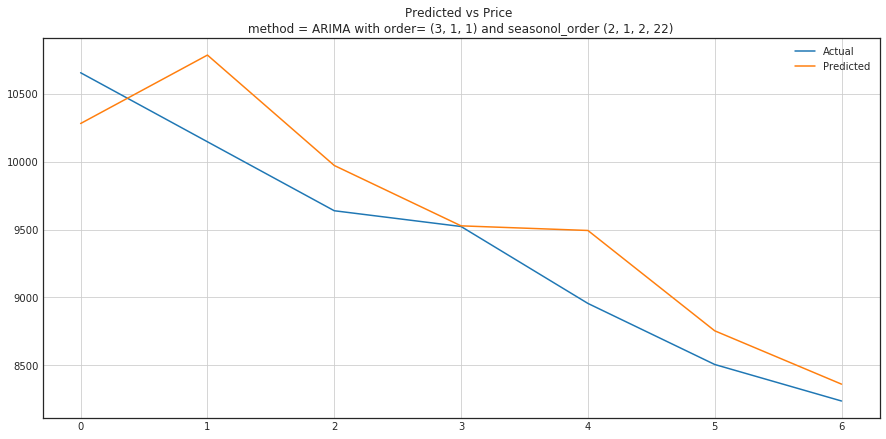

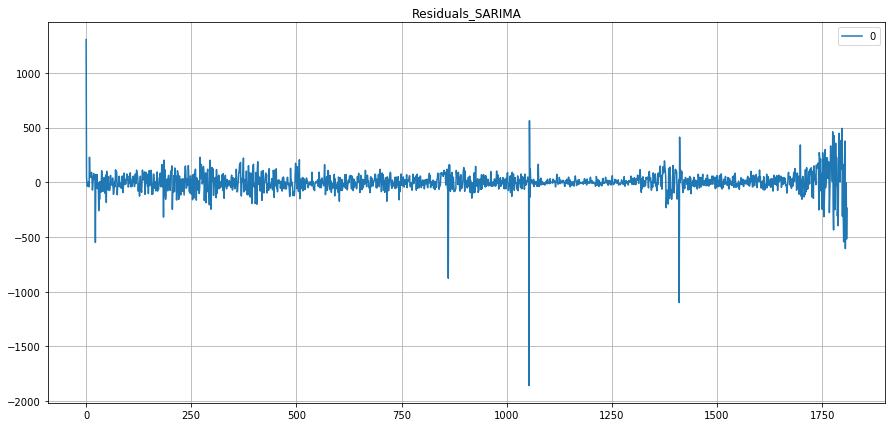

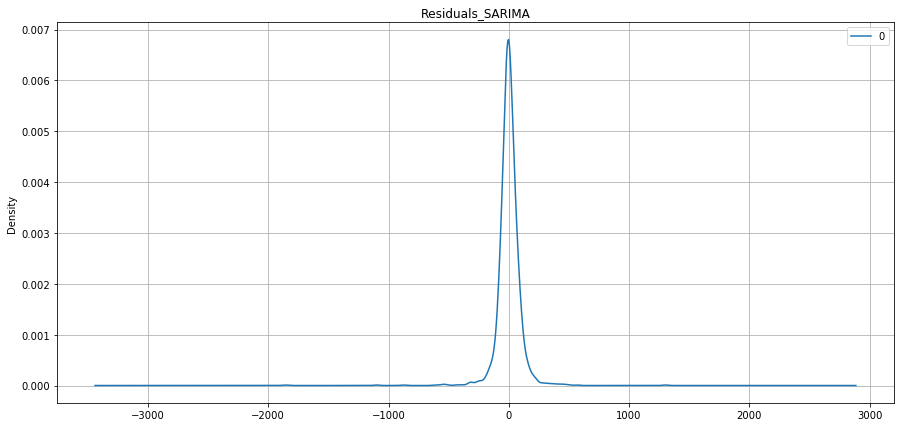

Residuals_SARIMA statistics:                   0
count  1810.000000
mean      0.989907
std     104.445679
min   -1858.701428
25%     -34.330288
50%      -1.768569
75%      38.949996
max    1304.000000


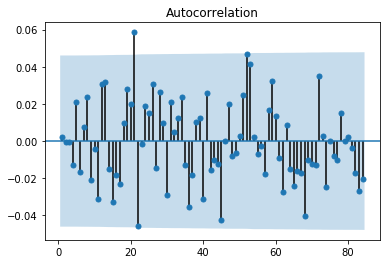

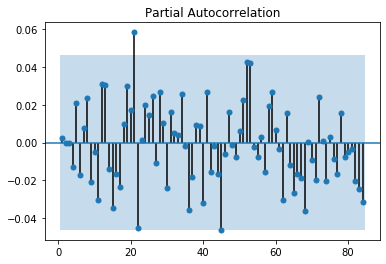

In [284]:
warnings.filterwarnings('ignore')
data = price
days_ahead = 7
order = (3,1,1) 
seasonal_order = (2,1,2,22)
predictions, test, model_fit = SARIMA_evaluate(data, order, seasonal_order)

print( "tomorrow's price:  =",  predictions[-1] ) 
error_SARIMA = mean_squared_error(test, predictions)
print("Error:  ", error_SARIMA)
for item in zip(predictions,test):
    print("Predicted:", '%.2f'%item[0], "  Actual: ", item[1]) 
predictions_SARIMA = predictions
plot_func_SARIMA (test, predictions, method = "ARIMA",order = order, seasonal_order = seasonal_order)


print("SARIMA Model's configuration:\n ", model_fit.summary())
residuals_SARIMA = pd.DataFrame(model_fit.resid)
residuals_SARIMA.plot(figsize= (15,7), grid = True)
plt.title("Residuals_SARIMA")
plt.show()
residuals_SARIMA.plot(kind='kde', figsize= (15,7), grid = True)
plt.title("Residuals_SARIMA")
plt.show()
print("Residuals_SARIMA statistics: ", residuals_SARIMA.describe())
_  = plot_acf(residuals_SARIMA,zero = False, lags = 84)
_ = plot_pacf(residuals_SARIMA,zero = False,lags = 84)

tomorrow's price:  = [8362.12600076]
Error:   145402.27631108803
Predicted: 10284.64   Actual:  10653.0
Predicted: 10776.18   Actual:  10145.2
Predicted: 9986.20   Actual:  9638.0
Predicted: 9527.55   Actual:  9522.0
Predicted: 9491.16   Actual:  8956.4
Predicted: 8755.17   Actual:  8507.2
Predicted: 8362.13   Actual:  8238.6
SARIMA Model's configuration:
                                          SARIMAX Results                                         
Dep. Variable:                                        y   No. Observations:                 1810
Model:             ARIMA(3, 1, 1)x(3, 1, [1, 2, 3], 22)   Log Likelihood              -10767.367
Date:                                  Tue, 18 Aug 2020   AIC                          21556.733
Time:                                          11:59:06   BIC                          21617.105
Sample:                                               0   HQIC                         21579.027
                                                 - 1810   

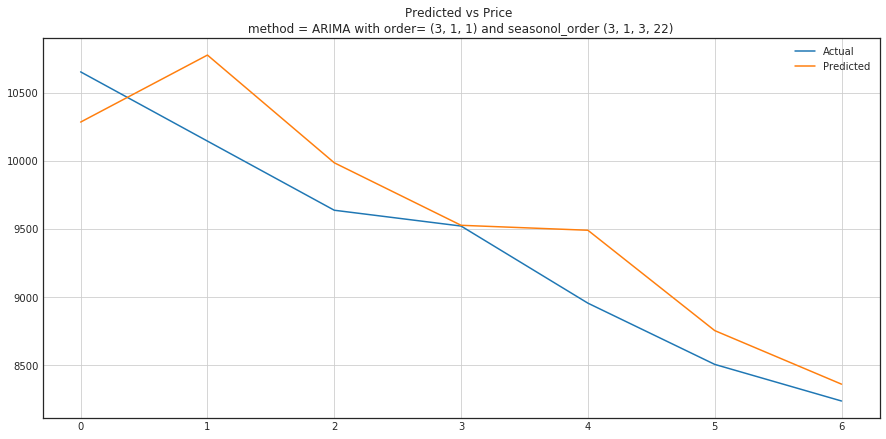

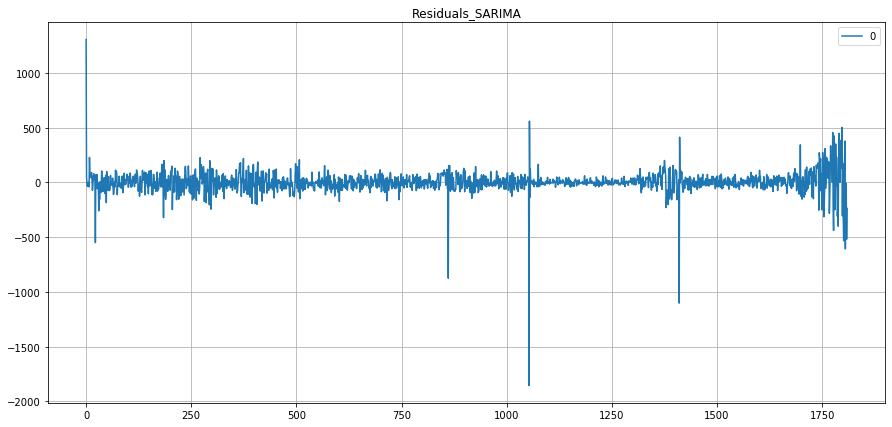

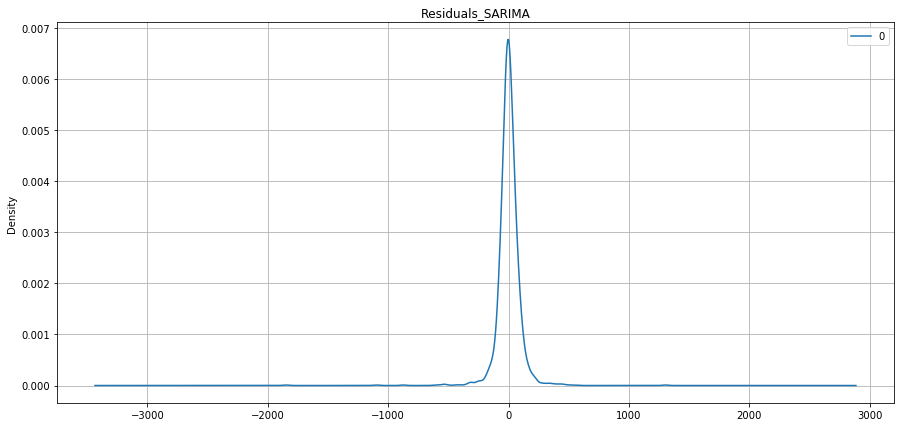

Residuals_SARIMA statistics:                   0
count  1810.000000
mean      1.002187
std     104.397317
min   -1855.140290
25%     -34.519482
50%      -1.340151
75%      39.203331
max    1304.000000


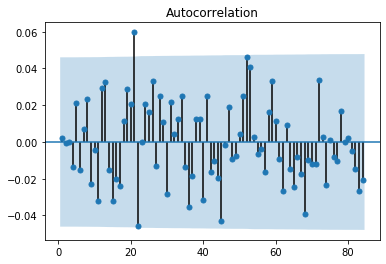

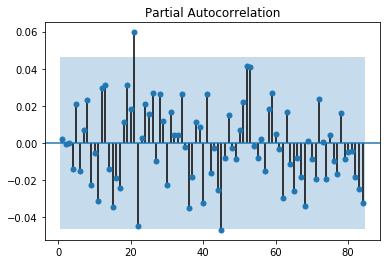

In [285]:
warnings.filterwarnings('ignore')
data = price
days_ahead = 7
order = (3,1,1) 
seasonal_order = (3,1,3,22)
predictions, test, model_fit = SARIMA_evaluate(data, order, seasonal_order)

print( "tomorrow's price:  =",  predictions[-1] ) 
error_SARIMA = mean_squared_error(test, predictions)
print("Error:  ", error_SARIMA)
for item in zip(predictions,test):
    print("Predicted:", '%.2f'%item[0], "  Actual: ", item[1]) 
predictions_SARIMA = predictions
plot_func_SARIMA (test, predictions, method = "ARIMA",order = order, seasonal_order = seasonal_order)


print("SARIMA Model's configuration:\n ", model_fit.summary())
residuals_SARIMA = pd.DataFrame(model_fit.resid)
residuals_SARIMA.plot(figsize= (15,7), grid = True)
plt.title("Residuals_SARIMA")
plt.show()
residuals_SARIMA.plot(kind='kde', figsize= (15,7), grid = True)
plt.title("Residuals_SARIMA")
plt.show()
print("Residuals_SARIMA statistics: ", residuals_SARIMA.describe())
_  = plot_acf(residuals_SARIMA,zero = False, lags = 84)
_ = plot_pacf(residuals_SARIMA,zero = False,lags = 84)

In [36]:
def prep_univariate_sequence(sequence, lag_steps):
    if type(sequence) is not(list):
        sequence = list(sequence)
    X,Y = [],[]
    for i in range(len(sequence)):
        end_index = i+lag_steps
        if end_index > len(sequence)-1:
            break       
        seq_X, seq_Y =sequence[i:end_index], sequence[end_index]
        X.append(seq_X)
        Y.append(seq_Y)
    return np.array(X), np.array(Y)



def prep_inputs(train,days_ahead):
    Inputs = [train[-days_ahead:]]
    input_ = train[-days_ahead:]
    for t in range(len(test)):
        input_.append(test[t])
        del input_[0]
        Inputs.append(input_[:])
    for i in range(len(Inputs)):
        Inputs[i] = np.array(Inputs[i]).reshape(1,days_ahead)
        
    return Inputs  

def plot_func(test, Pred, method):
    import matplotlib.pyplot as plt
    with plt.style.context('seaborn-white'):
        plt.figure(figsize=(15, 7))
        plt.plot(test, label = "Actual")
        plt.plot(Pred, label = "Predicted")
        plt.title("method: {}" .format(method))
        plt.legend(loc="best")
        plt.axis('tight')
        plt.grid(True)

        
#         plt.title("Predicted vs Price \n method = {} with order= {} ".format(method,order))
        


## Univariate Deep Learning Approaches:

### Multilayer Perceptron (MLP)
 Model checkpoint used to save the model with best reslts


In [171]:
from keras.models import Sequential
from keras.layers import Dense,BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam

data= price
lag_steps = 3
days_ahead = 7
train,test= split(data, days_ahead )
X,Y = prep_univariate_sequence(train, lag_steps)


### Create Model
model = Sequential()
model.add(Dense(81, activation='relu', input_dim=lag_steps))
model.add(Dense(3, activation='relu', input_dim=lag_steps))
model.add(Dense(1))


### Compile the model
# opt = Adam(learning_rate=0.001)
model.compile(optimizer= 'adam', loss='mse')

### checkpoint

filepath=r'StockDL\weights_MLP.best.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
# Fit the model
model.fit(X, Y, validation_split=0.2, epochs=400, callbacks=callbacks_list, verbose=0)

 


### Saved model with best results loaded for prediction

Predicted:  10317.96   Actual:  10653.0
Predicted:  10851.6045   Actual:  10145.2
Predicted:  9964.449   Actual:  9638.0
Predicted:  9556.837   Actual:  9522.0
Predicted:  9562.172   Actual:  8956.4
Predicted:  8809.622   Actual:  8507.2
Predicted:  8449.726   Actual:  8238.6
tomorrow's price:  = 8223.057
MSE for MLP:  174576.3605074472


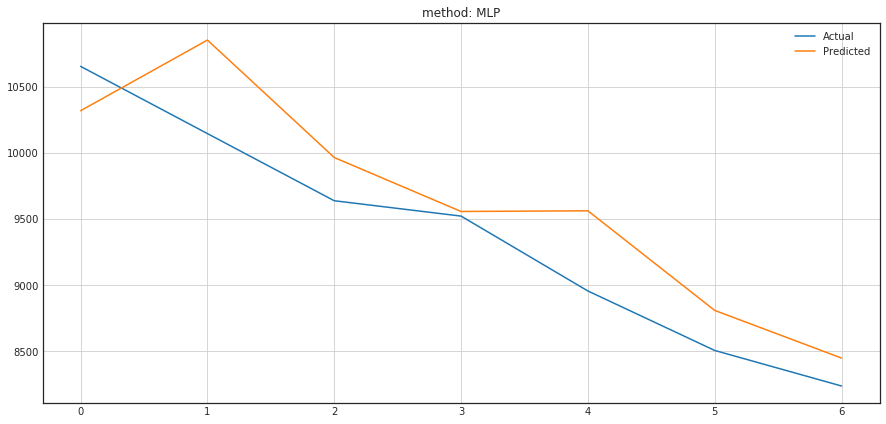

In [170]:
##Loading a Check-Pointed Neural Network Model
model.load_weights(filepath)

model.compile(optimizer='adam', loss='mse')

Inputs = prep_inputs(train,lag_steps)

predictions = []
for input_ in Inputs:
    yhat = model.predict(input_, verbose=0)
    predictions.append(yhat)
Pred = []
for i in range(len(predictions[:-1])):
    Pred.append(predictions[i][0][0])
for item in zip(Pred,test):
    print("Predicted: ", item[0], "  Actual: ", item[1]) 
print( "tomorrow's price:  =",   predictions[-1][0][0] )    
error_MLP = mean_squared_error(test, Pred)
print("MSE for MLP: ", error_MLP)
plot_func(test, Pred, method = "MLP")



### Convolutional Neural Network (CNN)
Best model saved

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

data= price
lag_steps = 3
days_ahead = 7
features = 1
train,test= split(data, days_ahead )
X,Y = prep_univariate_sequence(train, lag_steps)
X = X.reshape((X.shape[0], X.shape[1], 1))

### Create Model
model = Sequential()
model.add(Conv1D(filters=256, kernel_size=2, activation='relu', input_shape=(lag_steps, features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(81, activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1))

### Compile the model
# opt = Adam(learning_rate=0.001)
model.compile(optimizer= 'adam', loss='mse')

### checkpoint

filepath=r'StockDL\weights_CNN.best.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
# Fit the model
model.fit(X, Y, validation_split=0.33, epochs=400, callbacks=callbacks_list, verbose=0)



#### Best model loaded:

Predicted:  10074.169   Actual:  10653.0
Predicted:  10602.117   Actual:  10145.2
Predicted:  10339.669   Actual:  9638.0
Predicted:  9807.539   Actual:  9522.0
Predicted:  9456.875   Actual:  8956.4
Predicted:  9087.986   Actual:  8507.2
Predicted:  8636.763   Actual:  8238.6
tomorrow's price:  = 8257.131
MSE for CNN:  266287.4410904746


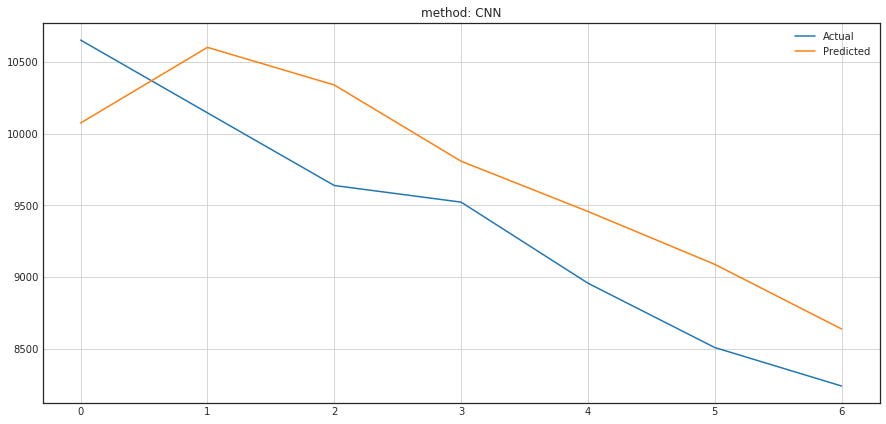

In [177]:
model.load_weights(filepath)

# model.compile(optimizer='adam', loss='mse')
Inputs = prep_inputs(train,lag_steps)
Inputs = np.array(Inputs).reshape(len(Inputs),1,lag_steps,features)
predictions = []
for input_ in Inputs:
    yhat = model.predict(input_, verbose=0)
    predictions.append(yhat)
Pred = []
for i in range(len(predictions[:-1])):
    Pred.append(predictions[i][0][0])
for item in zip(Pred,test):
    print("Predicted: ", item[0], "  Actual: ", item[1]) 
print( "tomorrow's price:  =",   predictions[-1][0][0] )    
error_CNN = mean_squared_error(test, Pred)
print("MSE for CNN: ", error_CNN)
plot_func(test, Pred,method = "CNN")


## LSTM Models for Time Series Forecasting (LSTM- univariate)
* Vanilla LSTM
* Stacked LSTM
* Bidirectional LSTM
* CNN LSTM
* ConvLSTM

### Vanilla LSTM: Best model saved:

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM


data= price
lag_steps = 3
features = 1
train,test= split(data, days_ahead)
X,Y = prep_univariate_sequence(train, lag_steps)
X = X.reshape((X.shape[0], X.shape[1], 1))
model = Sequential()
model.add(LSTM(81, activation='relu', input_shape=(lag_steps, features)))
model.add(Dense(27, activation='relu'))
model.add(Dense(1))




### Compile the model
# opt = Adam(learning_rate=0.001)
model.compile(optimizer= 'adam', loss='mse')

### checkpoint

# filepath=r'StockDL\weights_Van_LSTM.best.hdf5'
# checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
# callbacks_list = [checkpoint]
# # Fit the model
# model.fit(X, Y, validation_split=0.33, epochs=400, callbacks=callbacks_list, verbose=0)





#### Model loaded

Predicted:  10355.126   Actual:  10653.0
Predicted:  10849.605   Actual:  10145.2
Predicted:  9980.756   Actual:  9638.0
Predicted:  9577.785   Actual:  9522.0
Predicted:  9592.529   Actual:  8956.4
Predicted:  8828.734   Actual:  8507.2
Predicted:  8467.389   Actual:  8238.6
tomorrow's price:  = 8244.904
MSE for Vanilla LSTM:  197892.5928077423


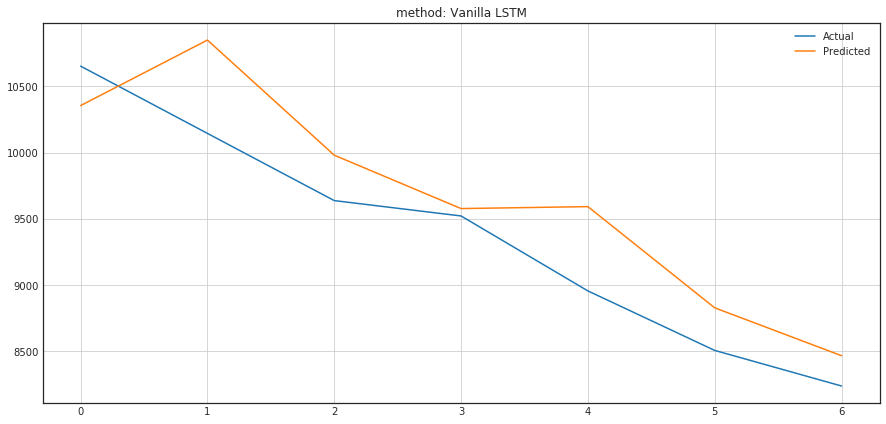

In [181]:
model.load_weights(filepath)
Inputs = prep_inputs(train,lag_steps)
Inputs = np.array(Inputs).reshape(len(Inputs),1,lag_steps,features)
predictions = []
for input_ in Inputs:
    yhat = model.predict(input_, verbose=0)
    predictions.append(yhat)
Pred = []
for i in range(len(predictions[:-1])):
    Pred.append(predictions[i][0][0])
for item in zip(Pred,test):
    print("Predicted: ", item[0], "  Actual: ", item[1]) 
print( "tomorrow's price:  =",   predictions[-1][0][0] )    
error_Van_LSTM = mean_squared_error(test, Pred)
print("MSE for Vanilla LSTM: ", error)
plot_func(test, Pred, method = "Vanilla LSTM")

### Stacked LSTM:
Model saved:

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM


data= price
lag_steps = 3
features = 1
days_ahead = 7

train,test= split(data, days_ahead)
X,Y = prep_univariate_sequence(train, lag_steps)
X = X.reshape((X.shape[0], X.shape[1], 1))

###Create Model
model = Sequential()
model.add(LSTM(81, activation='relu', return_sequences=True, input_shape=(lag_steps, features)))
model.add(LSTM(81, activation='relu'))
model.add(Dense(27, activation='relu'))
model.add(Dense(1))

## Complie model
model.compile(optimizer= 'adam', loss='mse')
### checkpoint

filepath=r'StockDL\weights_Stacked_LSTM.best.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
# Fit the model
model.fit(X, Y, validation_split=0.33, epochs=400, callbacks=callbacks_list, verbose=0)



#### Model loaded

Predicted:  10332.952   Actual:  10653.0
Predicted:  10830.678   Actual:  10145.2
Predicted:  9975.577   Actual:  9638.0
Predicted:  9561.803   Actual:  9522.0
Predicted:  9573.322   Actual:  8956.4
Predicted:  8819.237   Actual:  8507.2
Predicted:  8452.045   Actual:  8238.6
tomorrow's price:  = 8229.864
MSE for Stacked LSTM:  173053.1480627603


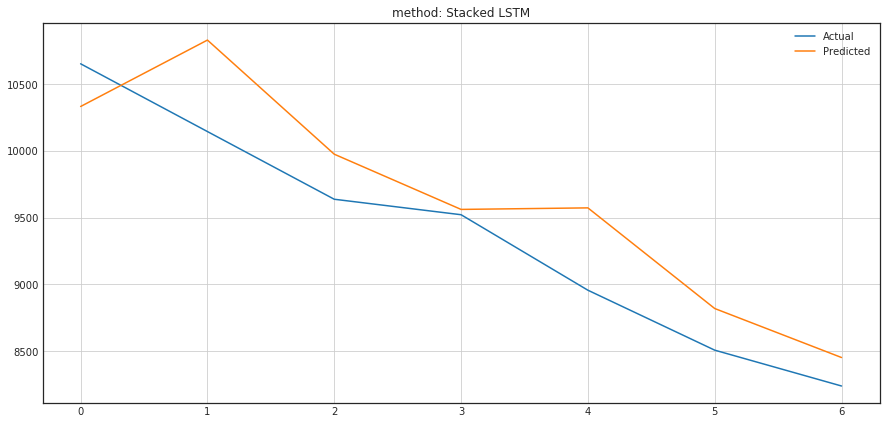

In [186]:
model.load_weights(filepath)
Inputs = prep_inputs(train,lag_steps)
Inputs = np.array(Inputs).reshape(len(Inputs),1,lag_steps,features)
predictions = []
for input_ in Inputs:
    yhat = model.predict(input_, verbose=0)
    predictions.append(yhat)
Pred = []
for i in range(len(predictions[:-1])):
    Pred.append(predictions[i][0][0])
for item in zip(Pred,test):
    print("Predicted: ", item[0], "  Actual: ", item[1]) 
print( "tomorrow's price:  =",   predictions[-1][0][0] )    
error_Stacked_LSTM = mean_squared_error(test, Pred)
print("MSE for Stacked LSTM: ", error_Stacked_LSTM )
plot_func(test, Pred, method = "Stacked LSTM")



### Bidirectional LSTM:
Model saved

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional


data= price
lag_steps = 3
features = 1
train,test= split(data, days_ahead)
X,Y = prep_univariate_sequence(train, lag_steps)
X = X.reshape((X.shape[0], X.shape[1], 1))
model = Sequential()
model.add(Bidirectional(LSTM(81, activation='relu'), input_shape=(lag_steps, features)))
model.add(Dense(27, activation='relu'))
model.add(Dense(1))

###Compile model
model.compile(optimizer='adam', loss='mse')


# #### checkpoint

filepath=r'StockDL\weights_Bidirectional_LSTM.best.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
# Fit the model
model.fit(X, Y, validation_split=0.33, epochs=400, callbacks=callbacks_list, verbose=0)



#### Model loaded

Predicted:  10357.518   Actual:  10653.0
Predicted:  10825.274   Actual:  10145.2
Predicted:  9952.188   Actual:  9638.0
Predicted:  9589.208   Actual:  9522.0
Predicted:  9596.302   Actual:  8956.4
Predicted:  8827.053   Actual:  8507.2
Predicted:  8482.368   Actual:  8238.6
tomorrow's price:  = 8251.098
MSE for Bidirectional LSTM:  174892.19065249286


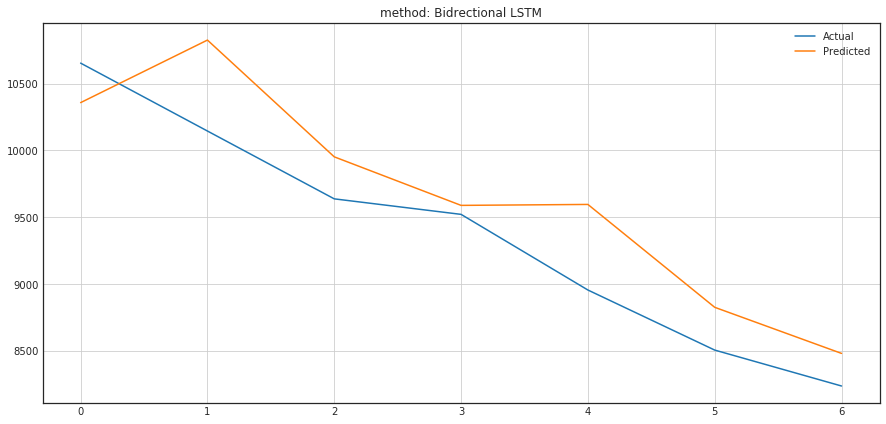

In [193]:
model.load_weights(filepath)
Inputs = prep_inputs(train,lag_steps)
Inputs = np.array(Inputs).reshape(len(Inputs),1,lag_steps,features)
predictions = []
for input_ in Inputs:
    yhat = model.predict(input_, verbose=0)
    predictions.append(yhat)
Pred = []
for i in range(len(predictions[:-1])):
    Pred.append(predictions[i][0][0])
for item in zip(Pred,test):
    print("Predicted: ", item[0], "  Actual: ", item[1]) 
print( "tomorrow's price:  =",   predictions[-1][0][0] )    
error_Bidrectional_LSTM = mean_squared_error(test, Pred)
print("MSE for Bidirectional LSTM: ", error_Bidrectional_LSTM )
plot_func(test, Pred, method = "Bidrectional LSTM")

 

### CNN LSTM:
* CNN model can be used in a hybrid model with an LSTM backend where the CNN is used to interpret subsequences of input that together are provided as a sequence to an LSTM model to interpret.
- A CNN model can be used in a hybrid model with an LSTM backend where the CNN is used to interpret subsequences of input that together are provided as a sequence to an LSTM model to interpret
* The first step is to split each input sequences into subsequences that can be processed by the CNN model.
- [samples, subsequences, timesteps, features]

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import TimeDistributed

data= price
features = 1
days_ahead = 7
lag_steps = 3
sub_steps = 3
n_seq = 1
train,test= split(data, days_ahead)
X,Y = prep_univariate_sequence(train, steps)

X = X.reshape((X.shape[0],n_seq,sub_steps,features))

#Create model

model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, sub_steps, features)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(81, activation='relu'))
model.add(Dense(27, activation='relu'))
model.add(Dense(1))

#compile model
model.compile(optimizer='adam', loss='mse')



#### checkpoint

filepath=r'StockDL\weights_CNN_LSTM.best.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
# Fit the model
model.fit(X, Y, validation_split=0.2, epochs=250, callbacks=callbacks_list, verbose=0)




#### Model loaded

Predicted:  10762.562   Actual:  10653.0
Predicted:  10277.38   Actual:  10145.2
Predicted:  10711.29   Actual:  9638.0
Predicted:  10711.29   Actual:  9522.0
Predicted:  10200.771   Actual:  8956.4
Predicted:  9690.858   Actual:  8507.2
Predicted:  9574.237   Actual:  8238.6
tomorrow's price:  = 9005.611
MSE for CNN-LSTM:  1047038.8798274992


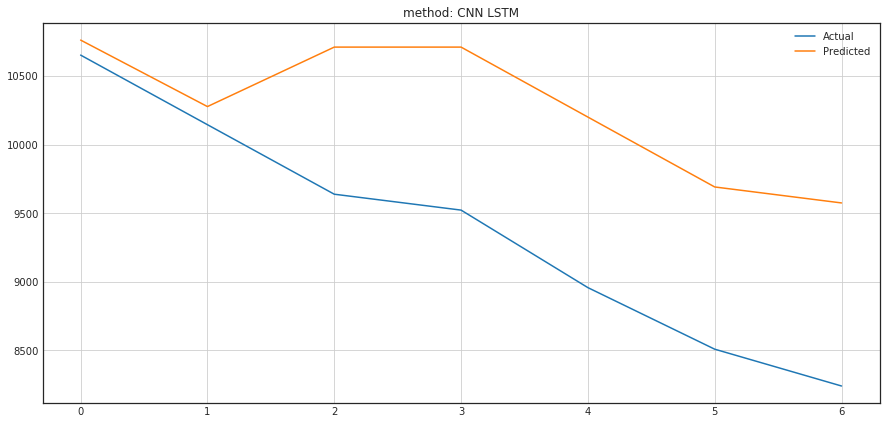

In [128]:
model.load_weights(filepath)
Inputs = prep_inputs(train,lag_steps)
Inputs = np.array(Inputs).reshape(len(Inputs), 1, n_seq, sub_steps, features)
predictions = []
for input_ in Inputs:
    yhat = model.predict(input_, verbose=0)
    predictions.append(yhat)
Pred = []
for i in range(len(predictions[:-1])):
    Pred.append(predictions[i][0][0])
for item in zip(Pred,test):
    print("Predicted: ", item[0], "  Actual: ", item[1]) 
print( "tomorrow's price:  =",   predictions[-1][0][0] )    
error_CNN_LSTM = mean_squared_error(test, Pred)
print("MSE for CNN-LSTM: ", error_CNN_LSTM)
plot_func(test, Pred, method = "CNN LSTM")


### ConvLSTM:
- A type of LSTM related to the CNN-LSTM is the ConvLSTM, where the convolutional reading of input is built directly into each LSTM unit.
- The layer expects input as a sequence of two-dimensional images, therefore the shape of input data must be:
- [samples, timesteps, rows, columns, features]

In [49]:
from keras.models import Sequential
from keras.layers import Dense,Flatten
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import TimeDistributed
from keras.layers import ConvLSTM2D
from keras.callbacks import ModelCheckpoint

data= price
features = 1
days_ahead = 7
lag_steps =3 
sub_steps =3
n_seq = 1
train,test= split(data, days_ahead)
X,Y = prep_univariate_sequence(train, lag_steps)

X = X.reshape((X.shape[0],n_seq,1,sub_steps,features))

#create model
model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,2), activation='relu', input_shape=(n_seq, 1, sub_steps, features)))
model.add(Flatten())
model.add(Dense(27, activation='relu'))
model.add(Dense(1))


##compile model
model.compile(optimizer='adam', loss='mse')




### checkpoint

filepath=r'StockDL\weights_ConvLSTM.best.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
# Fit the model
model.fit(X, Y, validation_split=0.33, epochs=400, callbacks=callbacks_list, verbose=0)



#### Model loaded

Predicted:  10349.011   Actual:  10653.0
Predicted:  10841.33   Actual:  10145.2
Predicted:  10022.409   Actual:  9638.0
Predicted:  9596.394   Actual:  9522.0
Predicted:  9593.867   Actual:  8956.4
Predicted:  8858.729   Actual:  8507.2
Predicted:  8481.072   Actual:  8238.6
tomorrow's price:  = 8253.221
MSE for ConvLSTM:  188434.41213953818


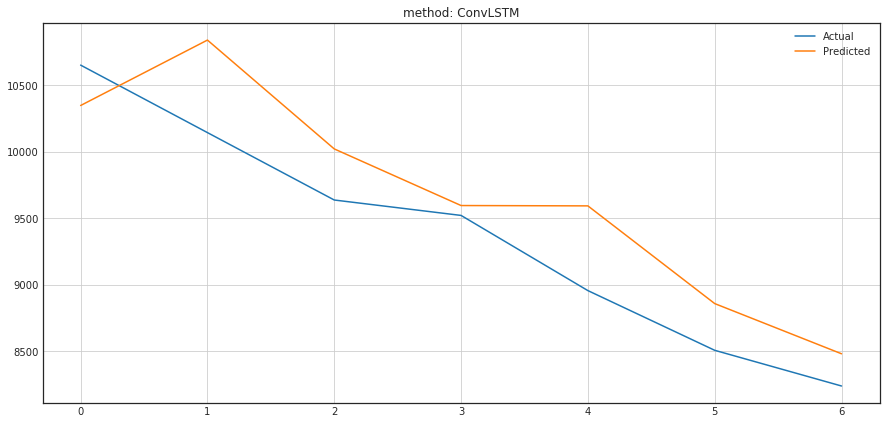

In [48]:
model.load_weights(filepath)
Inputs = prep_inputs(train,lag_steps)
Inputs = np.array(Inputs).reshape(len(Inputs), 1, n_seq,1, sub_steps, features)
predictions = []
for input_ in Inputs:
    yhat = model.predict(input_, verbose=0)
    predictions.append(yhat)
Pred = []
for i in range(len(predictions[:-1])):
    Pred.append(predictions[i][0][0])
for item in zip(Pred,test):
    print("Predicted: ", item[0], "  Actual: ", item[1]) 
print( "tomorrow's price:  =",   predictions[-1][0][0] )    
error_ConvLSTM = mean_squared_error(test, Pred)
print("MSE for ConvLSTM: ", error_ConvLSTM)
plot_func(test, Pred, method = "ConvLSTM") 


## Deep Learning- Multivariate

In [165]:
df.head()

,Date,First,High,Low,Close,Volumn,Num_trans,Open,Last,Day,week,Month,Year,ratio,price
0,2012-02-08,1304.0,1304.0,1304.0,1304.0,248387500,2061,1000.0,1304.0,Wednesday,6,February,2012,12051.795245,1304.0
1,2012-02-12,1369.0,1369.0,1320.0,1365.0,75848282,4290,1304.0,1369.0,Sunday,6,February,2012,1768.025221,1358.4
2,2012-02-13,1379.0,1397.0,1301.0,1350.0,23435322,2189,1365.0,1311.0,Monday,7,February,2012,1070.594884,1347.6
3,2012-02-14,1320.0,1324.0,1293.0,1304.0,12352753,1051,1350.0,1317.0,Tuesday,7,February,2012,1175.333302,1311.6
4,2012-02-15,1311.0,1324.0,1282.0,1301.0,9402675,680,1304.0,1290.0,Wednesday,7,February,2012,1382.746324,1301.6


In [615]:
df['Day'] = df['Day'].astype('category').cat.codes
df['week'] = df['week'].astype('category').cat.codes
df['Month'] = df['Month'].astype('category').cat.codes
df['Year'] = df['Year'].astype('category').cat.codes
df.head()

,Date,First,High,Low,Close,Volumn,Num_trans,Open,Last,Day,week,Month,Year,ratio,price
0,2012-02-08,1304.0,1304.0,1304.0,1304.0,248387500,2061,1000.0,1304.0,4,5,3,0,12051.795245,1304.0
1,2012-02-12,1369.0,1369.0,1320.0,1365.0,75848282,4290,1304.0,1369.0,2,5,3,0,1768.025221,1358.4
2,2012-02-13,1379.0,1397.0,1301.0,1350.0,23435322,2189,1365.0,1311.0,0,6,3,0,1070.594884,1347.6
3,2012-02-14,1320.0,1324.0,1293.0,1304.0,12352753,1051,1350.0,1317.0,3,6,3,0,1175.333302,1311.6
4,2012-02-15,1311.0,1324.0,1282.0,1301.0,9402675,680,1304.0,1290.0,4,6,3,0,1382.746324,1301.6


### Ratio defined as Volumn/Number_trans:  

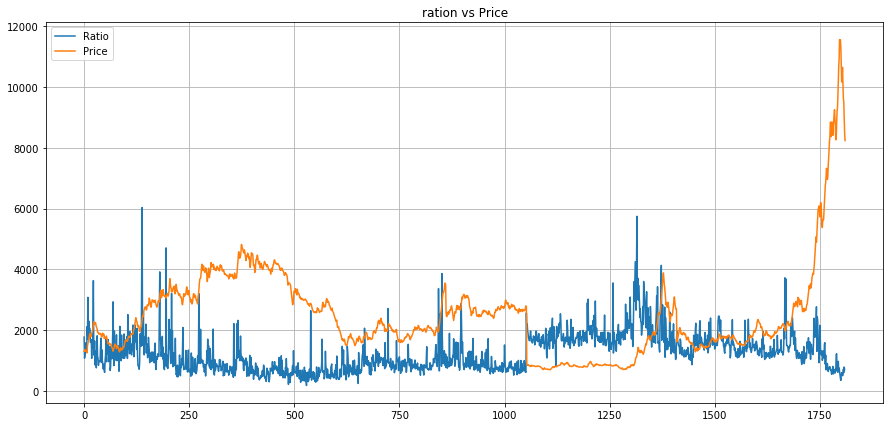

In [166]:
x = df.ratio.drop(0)
plt.figure(figsize=(15, 7))    
plt.title("ration vs Price")
plt.plot(x.values, label = "Ratio")
plt.plot(df.price.values, label = "Price")
plt.legend(loc="best")
plt.axis('tight')
plt.grid(True)

In [141]:
data1 = df.price.values
data2 = df.ratio.values
corr, _ = spearmanr(data1, data2)
print('Spearmans correlation\nfor nonlinear relation: %.3f' % corr)

Spearmans correlation
for nonlinear relation: -0.534


In [142]:
from scipy.stats import pearsonr
corr, _ = pearsonr(data1, data2)
print('Pearsons correlation\nthe strength of the linear relationship between two data samples:  %.3f' % corr)

Pearsons correlation
the strength of the linear relationship between two data samples:  -0.355


### With respect to the significant negative correlation between price and ratio (i.e. -0.53 per Spearmans:
- So here I used ratio along with price lags as inputs, whereas average price, High price, low price, Close plice, Last price and first price used as outputs seperately. So, for the next day each of these prices predicted seperately.  
- Under these consumptions the problem should be modeled as Multiple Input Series

### Multiple Input series with Stacked LSTM.
#### Functions:

In [513]:

def prep_multivariate_sequence_Series(sequence, lag_steps):
    X, Y = [],[]
    for i in range(len(sequence)):
        end_ix = i + lag_steps
        if end_ix > len(sequence)-1:
            break
        seq_X, seq_Y = sequence[i:end_ix, :-1], sequence[end_ix-1, -1]
        X.append(seq_X)
        Y.append(seq_Y)
    return np.array(X), np.array(Y)

def prep_multivariate_sequence_Parallel(sequence, lag_steps):
    X, Y = [],[]
    for i in range(len(sequence)):
        end_ix = i + lag_steps
        if end_ix > len(sequence)-1:
            break
        seq_X, seq_Y = sequence[i:end_ix, :], sequence[end_ix, :]
        X.append(seq_X)
        Y.append(seq_Y)
    return np.array(X), np.array(Y)





- Inputs: average price and ratio with lag order  = 3
- output: The average price of the next day
- The data is splited to train and test, model trained on X_train and Y_train and evaluated on X_test and Y_test

Predicted:  10221.8   Actual:  10221.4
Predicted:  10653.645   Actual:  10653.0
Predicted:  10142.773   Actual:  10145.2
Predicted:  9636.936   Actual:  9638.0
Predicted:  9522.013   Actual:  9522.0
Predicted:  8954.525   Actual:  8956.4
Predicted:  8506.508   Actual:  8507.2
tomorrow's price:  = [8238.107]
MSE for multivariate Stacked LSTM:  1.6557107652941612


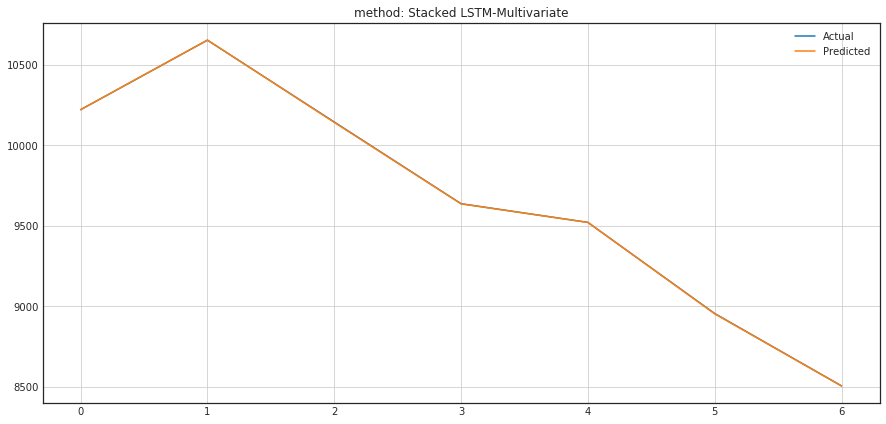

In [635]:
input_variables = ["price", "ratio"]
output_variable = ["price"]
sequence = df.loc[:,input_variables+output_variable].values
X,Y = prep_multivariate_sequence_Series(sequence, lag_steps = 3)

X_train,X_test = X[:-7][:][:],X[-7:][:][:]
Y_train,Y_test = Y[:-7],Y[-7:]
# define model
features = len(input_variables)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], features))
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(lag_steps, features)))
model.add(LSTM(100, activation='relu',input_shape=(lag_steps, features)))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')


model.fit(X_train, Y_train, epochs=1000, verbose=0)


predictions = []
for item in X_test:
    yhat = model.predict(item.reshape(1,lag_steps,features))
    predictions.append(yhat)

    
Pred = []
for i in range(len(predictions)):
    Pred.append(predictions[i][0][0])
    
for item in zip(Pred,Y_test):
    print("Predicted: ", item[0], "  Actual: ", item[1]) 


final_input = df.loc[1808:1811,["price","ratio"]].values

print( "tomorrow's price:  =",   model.predict(final_input.reshape(1,lag_steps,features))[0] )  


error_stacked_LSTM_mul = mean_squared_error(Y_test, Pred)
print("MSE for multivariate Stacked LSTM: ", error_stacked_LSTM_mul)
plot_func(Y_test, Pred, method = "Stacked LSTM-Multivariate") 
model.save('StockDL/LSTM-Series-with2_var_model.h5') 

### Examining if using all variables as input will further improve the result.
- Inputs: all prices and ratio with lags order  = 3
- Output: The average price of the next day 

Predicted:  10222.092   Actual:  10221.4
Predicted:  10652.049   Actual:  10653.0
Predicted:  10143.695   Actual:  10145.2
Predicted:  9640.432   Actual:  9638.0
Predicted:  9526.268   Actual:  9522.0
Predicted:  8954.237   Actual:  8956.4
Predicted:  8513.293   Actual:  8507.2
tomorrow's price:  = [8237.046]
MSE for multivariate Stacked LSTM:  9.939144815716318


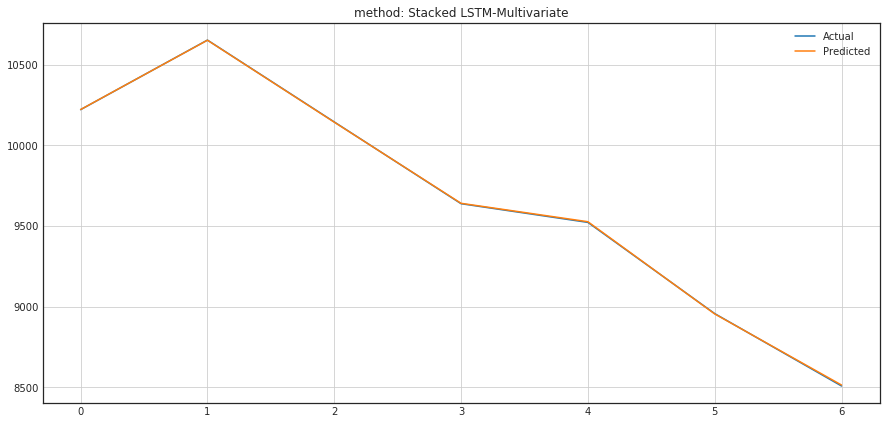

In [633]:
input_variables = ["First","High","Low","Close","Last","price","ratio"]
output_variable = ["price"]
sequence = df.loc[:,input_variables+output_variable].values
X,Y = prep_multivariate_sequence_Series(sequence, lag_steps = 3)

X_train,X_test = X[:-7][:][:],X[-7:][:][:]
Y_train,Y_test = Y[:-7],Y[-7:]
# define model
features = len(input_variables)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], features))
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(lag_steps, features)))
model.add(LSTM(100, activation='relu',input_shape=(lag_steps, features)))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')


model.fit(X_train, Y_train, epochs=1000, verbose=0)


predictions = []
for item in X_test:
    yhat = model.predict(item.reshape(1,lag_steps,features))
    predictions.append(yhat)

    
Pred = []
for i in range(len(predictions)):
    Pred.append(predictions[i][0][0])
    
for item in zip(Pred,Y_test):
    print("Predicted: ", item[0], "  Actual: ", item[1]) 

final_input = df.loc[1808:1811,["First","High","Low","Close","Last","price","ratio"]].values


print( "tomorrow's price:  =",   model.predict(final_input.reshape(1,lag_steps,features))[0] )  


error_stacked_LSTM_mul = mean_squared_error(Y_test, Pred)
print("MSE for multivariate Stacked LSTM: ", error_stacked_LSTM_mul)
plot_func(Y_test, Pred, method = "Stacked LSTM-Multivariate")    
model.save('StockDL/LSTM-Series-with_detail_vars_model.h5') 

### Further adding more input variables including day, week, month and year as input variables:
- Input: All prices and ratio with their correspondent lags along with date variables 
- Week, Day, Month and Year as categorical variables transformed into numerical
- Output: The average price of the next day


Predicted:  10214.864   Actual:  10221.4
Predicted:  10644.958   Actual:  10653.0
Predicted:  10116.479   Actual:  10145.2
Predicted:  9618.162   Actual:  9638.0
Predicted:  9510.785   Actual:  9522.0
Predicted:  8932.131   Actual:  8956.4
Predicted:  8489.529   Actual:  8507.2
tomorrow's price:  = [8226.639]
MSE for multivariate Stacked LSTM:  336.1246841975685


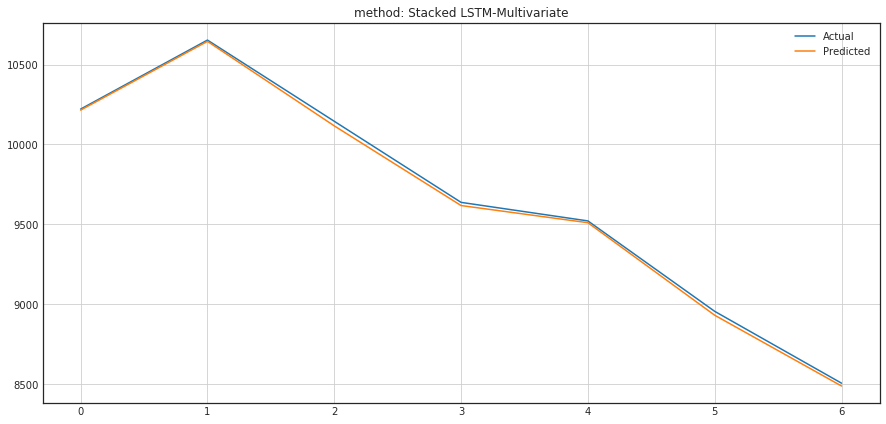

In [636]:
input_variables = ["First","High","Low","Close","Last","price","Month","Day","week","Year","ratio"]
output_variable = ["price"]

sequence = df.loc[:,input_variables+output_variable].values
X,Y = prep_multivariate_sequence_Series(sequence, lag_steps = 3)

X_train,X_test = X[:-7][:][:],X[-7:][:][:]
Y_train,Y_test = Y[:-7],Y[-7:]
# define model
features = len(input_variables)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], features))
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(lag_steps, features)))
model.add(LSTM(100, activation='relu',input_shape=(lag_steps, features)))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')


model.fit(X_train, Y_train, epochs=1000, verbose=0)


predictions = []
for item in X_test:
    yhat = model.predict(item.reshape(1,lag_steps,features))
    predictions.append(yhat)

    
Pred = []
for i in range(len(predictions)):
    Pred.append(predictions[i][0][0])
    
for item in zip(Pred,Y_test):
    print("Predicted: ", item[0], "  Actual: ", item[1]) 

final_input = df.loc[1808:1811,["First","High","Low","Close","Last","price","Month","Day","week","Year","ratio"]].values


print( "tomorrow's price:  =",   model.predict(final_input.reshape(1,lag_steps,features))[0] )  


error_stacked_LSTM_mul = mean_squared_error(Y_test, Pred)
print("MSE for multivariate Stacked LSTM: ", error_stacked_LSTM_mul)
plot_func(Y_test, Pred, method = "Stacked LSTM-Multivariate")    
model.save('StockDL/LSTM-Series-with_detail_vars_and_date_var_model.h5')

### Comparing the results in the last three cells:
- Only using ratio along with price with lags leads to better results
- Consequently, Each of the First, Last, Close, High, Low similarly predicted individually
- So for tomorrow's prediction each of price details will be predict seperatley

- Inputs: High price and ratio with lag order  = 3
- output: The High price of the next day
- The data is splited to train and test, model trained on X_train and Y_train and evaluated on X_test and Y_test

Predicted max:  10672.081   Actual max:  10677.0
Predicted max:  10745.436   Actual max:  10748.0
Predicted max:  10143.98   Actual max:  10146.0
Predicted max:  9637.127   Actual max:  9638.0
Predicted max:  10069.15   Actual max:  10070.0
Predicted max:  9066.44   Actual max:  9070.0
Predicted max:  8594.477   Actual max:  8595.0
tomorrow's max price:  = [8449.761]
MSE for multivariate Stacked LSTM for Max price:  7.039931978498187


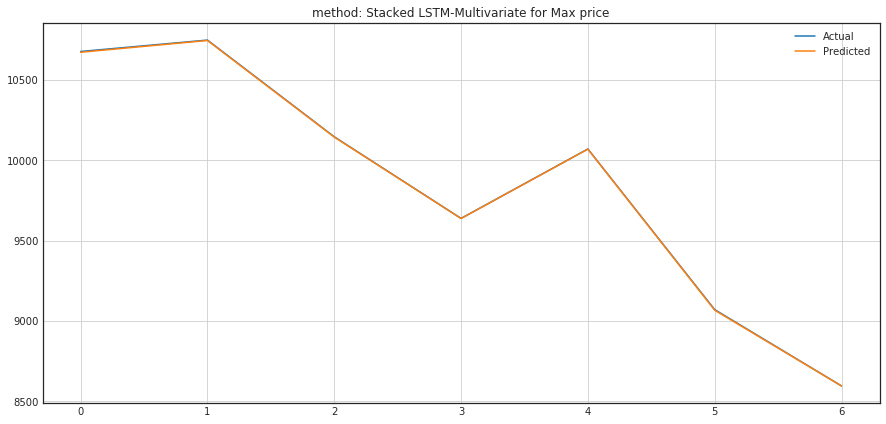

In [641]:
input_variables = ["High", "ratio"]
output_variable = ["High"]
sequence = df.loc[:,input_variables+output_variable].values
X,Y = prep_multivariate_sequence_Series(sequence, lag_steps = 3)

X_train,X_test = X[:-7][:][:],X[-7:][:][:]
Y_train,Y_test = Y[:-7],Y[-7:]
# define model
features = len(input_variables)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], features))
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(lag_steps, features)))
model.add(LSTM(100, activation='relu',input_shape=(lag_steps, features)))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')


model.fit(X_train, Y_train, epochs=1000, verbose=0)


predictions = []
for item in X_test:
    yhat = model.predict(item.reshape(1,lag_steps,features))
    predictions.append(yhat)

    
Pred = []
for i in range(len(predictions)):
    Pred.append(predictions[i][0][0])
    
for item in zip(Pred,Y_test):
    print("Predicted max: ", item[0], "  Actual max: ", item[1]) 


final_input = df.loc[1808:1811,["High","ratio"]].values

print( "tomorrow's max price:  =",   model.predict(final_input.reshape(1,lag_steps,features))[0] )  


error_stacked_LSTM_mul_max = mean_squared_error(Y_test, Pred)
print("MSE for multivariate Stacked LSTM for Max price: ", error_stacked_LSTM_mul_max)
plot_func(Y_test, Pred, method = "Stacked LSTM-Multivariate for Max price") 
model.save('StockDL/LSTM-Series-with2_var_Max_price_model.h5') 

- Inputs: Low price and ratio with lag order  = 3
- output: The Low price of the next day
- The data is splited to train and test, model trained on X_train and Y_train and evaluated on X_test and Y_test

Predicted min:  9661.164   Actual min:  9661.0
Predicted min:  10401.809   Actual min:  10400.0
Predicted min:  10144.916   Actual min:  10145.0
Predicted min:  9638.252   Actual min:  9638.0
Predicted min:  9157.436   Actual min:  9157.0
Predicted min:  8927.679   Actual min:  8927.0
Predicted min:  8485.274   Actual min:  8485.0
tomorrow's min price:  = [8062.4126]
MSE for multivariate Stacked LSTM for Min price:  0.5848734719412667


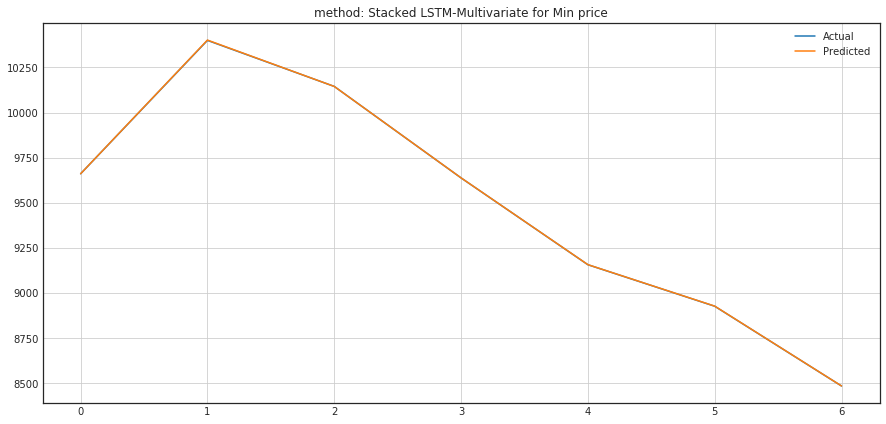

In [642]:
input_variables = ["Low", "ratio"]
output_variable = ["Low"]
sequence = df.loc[:,input_variables+output_variable].values
X,Y = prep_multivariate_sequence_Series(sequence, lag_steps = 3)

X_train,X_test = X[:-7][:][:],X[-7:][:][:]
Y_train,Y_test = Y[:-7],Y[-7:]
# define model
features = len(input_variables)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], features))
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(lag_steps, features)))
model.add(LSTM(100, activation='relu',input_shape=(lag_steps, features)))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')


model.fit(X_train, Y_train, epochs=1000, verbose=0)


predictions = []
for item in X_test:
    yhat = model.predict(item.reshape(1,lag_steps,features))
    predictions.append(yhat)

    
Pred = []
for i in range(len(predictions)):
    Pred.append(predictions[i][0][0])
    
for item in zip(Pred,Y_test):
    print("Predicted min: ", item[0], "  Actual min: ", item[1]) 


final_input = df.loc[1808:1811,["Low","ratio"]].values

print( "tomorrow's min price:  =",   model.predict(final_input.reshape(1,lag_steps,features))[0] )  


error_stacked_LSTM_mul_min = mean_squared_error(Y_test, Pred)
print("MSE for multivariate Stacked LSTM for Min price: ", error_stacked_LSTM_mul_min)
plot_func(Y_test, Pred, method = "Stacked LSTM-Multivariate for Min price") 
model.save('StockDL/LSTM-Series-with2_var_Min_price_model.h5') 

- Inputs: Fist price and ratio with lag order  = 3
- output: The First price of the next day
- The data is splited to train and test, model trained on X_train and Y_train and evaluated on X_test and Y_test

Predicted First:  9998.638   Actual First:  10000.0
Predicted First:  10718.257   Actual First:  10720.0
Predicted First:  10143.011   Actual First:  10145.0
Predicted First:  9636.5625   Actual First:  9638.0
Predicted First:  9828.518   Actual First:  9830.0
Predicted First:  8925.458   Actual First:  8927.0
Predicted First:  8483.894   Actual First:  8485.0
tomorrow's First price:  = [8193.823]
MSE for multivariate Stacked LSTM for Min price:  2.388226236615862


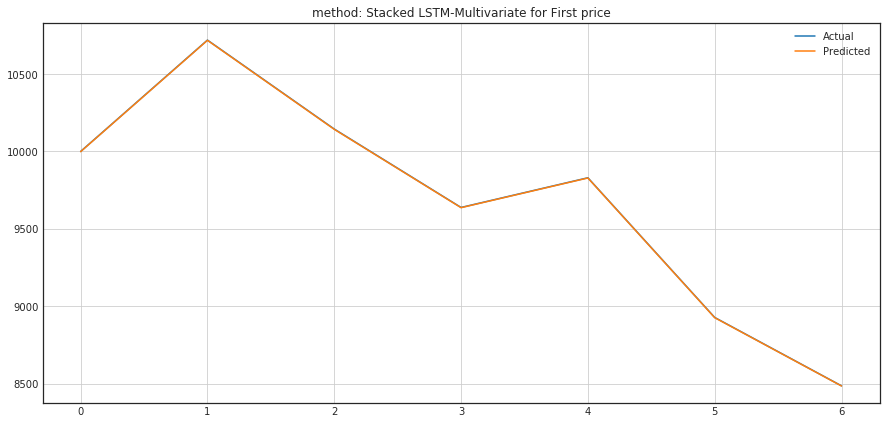

In [647]:
input_variables = ["First", "ratio"]
output_variable = ["First"]
sequence = df.loc[:,input_variables+output_variable].values
X,Y = prep_multivariate_sequence_Series(sequence, lag_steps = 3)

X_train,X_test = X[:-7][:][:],X[-7:][:][:]
Y_train,Y_test = Y[:-7],Y[-7:]
# define model
features = len(input_variables)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], features))
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(lag_steps, features)))
model.add(LSTM(100, activation='relu',input_shape=(lag_steps, features)))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')


model.fit(X_train, Y_train, epochs=1000, verbose=0)


predictions = []
for item in X_test:
    yhat = model.predict(item.reshape(1,lag_steps,features))
    predictions.append(yhat)

    
Pred = []
for i in range(len(predictions)):
    Pred.append(predictions[i][0][0])
    
for item in zip(Pred,Y_test):
    print("Predicted First: ", item[0], "  Actual First: ", item[1]) 


final_input = df.loc[1808:1811,["First","ratio"]].values

print( "tomorrow's First price:  =",   model.predict(final_input.reshape(1,lag_steps,features))[0] )  


error_stacked_LSTM_mul_First = mean_squared_error(Y_test, Pred)
print("MSE for multivariate Stacked LSTM for Min price: ", error_stacked_LSTM_mul_First)
plot_func(Y_test, Pred, method = "Stacked LSTM-Multivariate for First price") 
model.save('StockDL/LSTM-Series-with2_var_First_price_model.h5') 

- Inputs: Close price and ratio with lag order  = 3
- output: The Close price of the next day
- The data is splited to train and test, model trained on X_train and Y_train and evaluated on X_test and Y_test

Predicted Close:  10236.178   Actual Close:  10237.0
Predicted Close:  10676.187   Actual Close:  10678.0
Predicted Close:  10141.711   Actual Close:  10145.0
Predicted Close:  9636.994   Actual Close:  9638.0
Predicted Close:  9395.093   Actual Close:  9396.0
Predicted Close:  8929.539   Actual Close:  8931.0
Predicted Close:  8485.155   Actual Close:  8486.0
tomorrow's Close price:  = [8135.302]
MSE for multivariate Stacked LSTM for Close price:  2.78078065599714


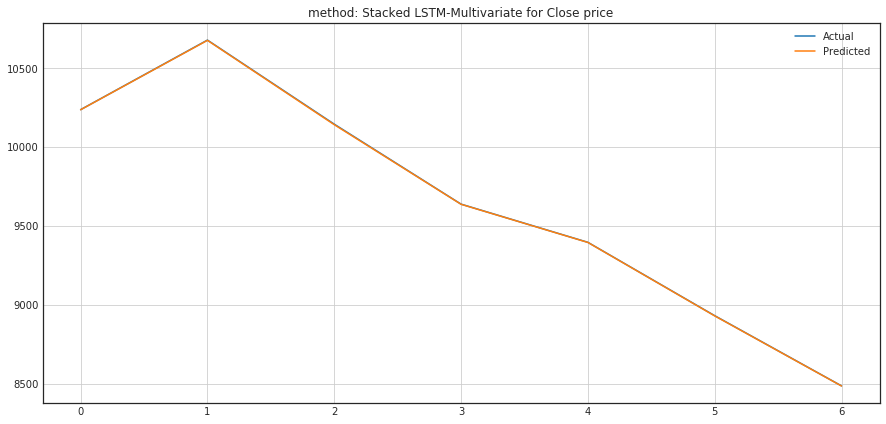

In [643]:
input_variables = ["Close", "ratio"]
output_variable = ["Close"]
sequence = df.loc[:,input_variables+output_variable].values
X,Y = prep_multivariate_sequence_Series(sequence, lag_steps = 3)

X_train,X_test = X[:-7][:][:],X[-7:][:][:]
Y_train,Y_test = Y[:-7],Y[-7:]
# define model
features = len(input_variables)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], features))
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(lag_steps, features)))
model.add(LSTM(100, activation='relu',input_shape=(lag_steps, features)))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')


model.fit(X_train, Y_train, epochs=1000, verbose=0)


predictions = []
for item in X_test:
    yhat = model.predict(item.reshape(1,lag_steps,features))
    predictions.append(yhat)

    
Pred = []
for i in range(len(predictions)):
    Pred.append(predictions[i][0][0])
    
    
for item in zip(Pred,Y_test):
    print("Predicted Close: ", item[0], "  Actual Close: ", item[1]) 


final_input = df.loc[1808:1811,["Close","ratio"]].values

print( "tomorrow's Close price:  =",   model.predict(final_input.reshape(1,lag_steps,features))[0] )  


error_stacked_LSTM_mul_Close = mean_squared_error(Y_test, Pred)
print("MSE for multivariate Stacked LSTM for Close price: ", error_stacked_LSTM_mul_Close)
plot_func(Y_test, Pred, method = "Stacked LSTM-Multivariate for Close price") 
model.save('StockDL/LSTM-Series-with2_var_Close_price_model.h5') 

- Inputs: Last price and ratio with lag order  = 3
- output: The Last price of the next day
- The data is splited to train and test, model trained on X_train and Y_train and evaluated on X_test and Y_test

Predicted Last:  10530.462   Actual Last:  10532.0
Predicted Last:  10715.779   Actual Last:  10719.0
Predicted Last:  10141.692   Actual Last:  10145.0
Predicted Last:  9636.129   Actual Last:  9638.0
Predicted Last:  9155.183   Actual Last:  9157.0
Predicted Last:  8925.447   Actual Last:  8927.0
Predicted Last:  8482.898   Actual Last:  8485.0
tomorrow's Last price:  = [8348.6]
MSE for multivariate Stacked LSTM for Last price:  5.33005564553397


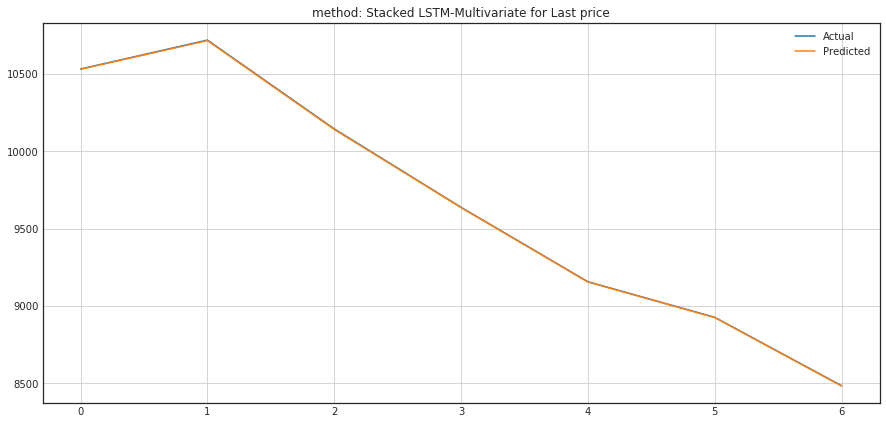

In [648]:
input_variables = ["Last", "ratio"]
output_variable = ["Last"]
sequence = df.loc[:,input_variables+output_variable].values
X,Y = prep_multivariate_sequence_Series(sequence, lag_steps = 3)

X_train,X_test = X[:-7][:][:],X[-7:][:][:]
Y_train,Y_test = Y[:-7],Y[-7:]
# define model
features = len(input_variables)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], features))
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(lag_steps, features)))
model.add(LSTM(100, activation='relu',input_shape=(lag_steps, features)))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')


model.fit(X_train, Y_train, epochs=1000, verbose=0)


predictions = []
for item in X_test:
    yhat = model.predict(item.reshape(1,lag_steps,features))
    predictions.append(yhat)

    
Pred = []
for i in range(len(predictions)):
    Pred.append(predictions[i][0][0])
    
for item in zip(Pred,Y_test):
    print("Predicted Last: ", item[0], "  Actual Last: ", item[1]) 


final_input = df.loc[1808:1811,["Last","ratio"]].values

print( "tomorrow's Last price:  =",   model.predict(final_input.reshape(1,lag_steps,features))[0] )  


error_stacked_LSTM_mul_Last = mean_squared_error(Y_test, Pred)
print("MSE for multivariate Stacked LSTM for Last price: ", error_stacked_LSTM_mul_Last)
plot_func(Y_test, Pred, method = "Stacked LSTM-Multivariate for Last price") 
model.save('StockDL/LSTM-Series-with2_var_Last_price_model.h5') 

### Multiple Parallel Series:
- In parallel mode, a value will be predicted for each.
- Inputs: "First","High","Low","Close","Last","price","ratio"
- Outputs: "First","High","Low","Close","Last","price","ratio"

Predicted:  [10573.727  10849.417  10320.8545 10614.2    10564.403 ] 
Actual:  [10720.         10748.         10400.         10678.
 10719.           522.64977159]
Predicted:  [10808.014 11036.369 10464.131 10772.288 10703.515] 
Actual:  [10145.         10146.         10145.         10145.
 10145.           497.07972368]
Predicted:  [10013.976 10297.536  9796.263 10032.33  10003.77 ] 
Actual:  [9638.         9638.         9638.         9638.         9638.
  501.88142582]
Predicted:  [9501.62  9803.058 9329.875 9552.094 9567.605] 
Actual:  [ 9830.         10070.          9157.          9396.
  9157.           701.06649164]
Predicted:  [9124.659  9446.513  8991.384  9192.281  9203.6455] 
Actual:  [8927.         9070.         8927.         8931.         8927.
  596.51526952]
Predicted:  [8879.944 9149.034 8713.164 8917.466 8922.774] 
Actual:  [8485.         8595.         8485.         8486.         8485.
  779.71353567]
Predicted:  [8438.709  8693.0205 8290.891  8481.853  8496.594 ] 
Actu

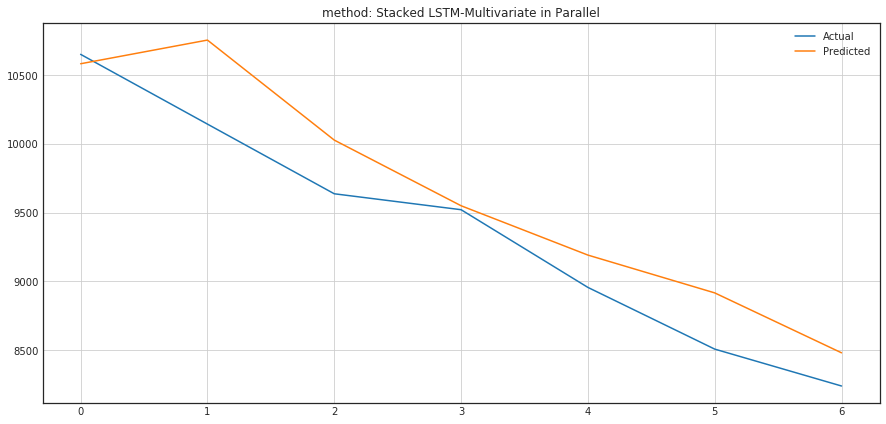

In [583]:
sequence_parallel = df.loc[:,["First","High","Low","Close","Last","ratio"]].values
X_par,Y_par = prep_multivariate_sequence_Parallel(sequence_parallel, lag_steps = 3)
X_train,X_test = X_par[:-7][:][:],X_par[-7:][:][:]
Y_train,Y_test = Y_par[:-7],Y_par[-7:]



features = X_par.shape[2]
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(lag_steps, features)))
model.add(LSTM(100, activation='relu'))
model.add(Dense(features))
model.compile(optimizer='adam', loss='mse')
# # fit model

model.fit(X_train, Y_train, epochs=1500, verbose=0)


predictions = []
for item in X_test:
    yhat = model.predict(item.reshape(1,lag_steps,features))
    predictions.append(yhat.reshape(-1))

    
Pred = []
for i in range(len(predictions)):
    Pred.append(predictions[i][:-1][:])
    
for item in zip(Pred,Y_test[:,:-1]):
    print("Predicted: ", item[0], "\nActual: ", item[1]) 

avg_pred, avg_actual = [] , []    
for item in zip(Pred,Y_test[:,:-1]):
    print("Average Price Predicted: ", np.mean(item[0]), "Average Actual: ", np.mean(item[1])) 
    avg_pred.append(np.mean(item[0]))
    avg_actual.append(np.mean(item[1]))
    
print( "tomorrow's average price:  =", avg_pred[-1]   ) 
print( "tomorrow's price with details:  =", predictions[-1][:-1][:]  ) 

error_stacked_LSTM_mul_parallel = mean_squared_error(avg_actual, avg_pred)
print("MSE for multivariate Stacked LSTM in Parallel: ", error_stacked_LSTM_mul_parallel )
plot_func(avg_actual, avg_pred, method = "Stacked LSTM-Multivariate in Parallel")   

#### Comparing Results it is seen Multiple Input series shows better results compared with Multiple Parallel Series.

#### Loading the saved Deep learning models as follows:

In [5]:
import os
from keras.models import load_model
file_path  = r"---"

os.listdir(file_path)
models= {}
for model in os.listdir(file_path):
    models[model] = load_model(os.path.join(file_path, model))

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


#### Considering the Mean Square error it looks almost perfect. Consequently, the updated data downloaded as follows, to see how does it performs on real unseen data:

In [3]:
import pandas as pd
data_path = r"--"
New_df = pd.read_csv(data_path)
New_df.drop(['<TICKER>', '<VALUE>', '<PER>'], axis =1, inplace=True)
cols = ['Date', 'First', 'High', 'Low', 'Close', 'Volumn','Num_trans', 'Open','Last']
New_df.columns = cols
New_df.Date = New_df.Date.astype(str)
New_df.Date = pd.to_datetime(New_df.Date)
New_df['ratio'] = New_df['Volumn']/New_df['Num_trans']
New_df['ratio'] = New_df['ratio']/10
New_df.sort_values('Date',inplace = True)
New_df.reset_index(inplace = True)
New_df.drop('index', inplace = True, axis = 1)
New_df['price'] = New_df.loc[:,['First','High','Low','Close','Last']].mean(axis = 1)
New_df.tail()

,Date,First,High,Low,Close,Volumn,Num_trans,Open,Last,ratio,price
1809,2020-08-16,8485.0,8595.0,8485.0,8486.0,105588807,13542,8931.0,8485.0,779.713536,8507.2
1810,2020-08-17,8195.0,8450.0,8062.0,8136.0,302612530,43274,8486.0,8350.0,699.294103,8238.6
1811,2020-08-18,8542.0,8542.0,7930.0,8405.0,202835663,38792,8136.0,8000.0,522.880138,8283.8
1812,2020-08-19,7985.0,7985.0,7985.0,7985.0,15526692,4393,8405.0,7985.0,353.441657,7985.0
1813,2020-08-22,8001.0,8220.0,7586.0,7660.0,203452896,27569,7985.0,7586.0,737.977061,7810.6


In [2]:
print("Last time model trained: I used until 2020-08-17")

Last time model trained: I used until 2020-08-17


#### Following cell prepares the inputs and outputs:

In [6]:
l1 = ['ratio','ratio','ratio','ratio','ratio','ratio']
l2 = ['price','High','Low','First','Close','Last']
l3 = [models['LSTM-Series-with2_var_model.h5'],
      models['LSTM-Series-with2_var_Max_price_model.h5'],
      models['LSTM-Series-with2_var_Min_price_model.h5'],
      models['LSTM-Series-with2_var_First_price_model.h5'],   
      models['LSTM-Series-with2_var_Close_price_model.h5'],
      models['LSTM-Series-with2_var_Last_price_model.h5']
      ]
index = [1808,1809,1810]
##Inputs disctionary
d1 = {}
###output dictionary
d2 = {}        
for i in index:
    for item in zip (l2,l1,l3):
        d1["Input_"+str(i+3)+"_"+ list(item)[0]]= New_df.loc[i:i+2, list(item)[:-1]]
        value = d1["Input_"+str(i+3)+"_"+ list(item)[0]].values.reshape(1,3,2)
        yhat = list(item)[-1].predict(value)[0]
        d2["Output_"+str(i+3)+"_"+ list(item)[0]] = yhat[0]


In [10]:
d1

{'Input_1811_price':        price       ratio
 1808  8956.4  596.515270
 1809  8507.2  779.713536
 1810  8238.6  699.294103,
 'Input_1811_High':         High       ratio
 1808  9070.0  596.515270
 1809  8595.0  779.713536
 1810  8450.0  699.294103,
 'Input_1811_Low':          Low       ratio
 1808  8927.0  596.515270
 1809  8485.0  779.713536
 1810  8062.0  699.294103,
 'Input_1811_First':        First       ratio
 1808  8927.0  596.515270
 1809  8485.0  779.713536
 1810  8195.0  699.294103,
 'Input_1811_Close':        Close       ratio
 1808  8931.0  596.515270
 1809  8486.0  779.713536
 1810  8136.0  699.294103,
 'Input_1811_Last':         Last       ratio
 1808  8927.0  596.515270
 1809  8485.0  779.713536
 1810  8350.0  699.294103,
 'Input_1812_price':        price       ratio
 1809  8507.2  779.713536
 1810  8238.6  699.294103
 1811  8283.8  522.880138,
 'Input_1812_High':         High       ratio
 1809  8595.0  779.713536
 1810  8450.0  699.294103
 1811  8542.0  522.880138,
 'Inp

In [11]:
d2

{'Output_1811_price': 8238.107,
 'Output_1811_High': 8449.761,
 'Output_1811_Low': 8062.4126,
 'Output_1811_First': 8193.823,
 'Output_1811_Close': 8135.302,
 'Output_1811_Last': 8348.6,
 'Output_1812_price': 8284.086,
 'Output_1812_High': 8541.62,
 'Output_1812_Low': 7930.6743,
 'Output_1812_First': 8540.667,
 'Output_1812_Close': 8404.686,
 'Output_1812_Last': 7997.9175,
 'Output_1813_price': 7983.894,
 'Output_1813_High': 7983.2217,
 'Output_1813_Low': 7985.6597,
 'Output_1813_First': 7983.49,
 'Output_1813_Close': 7982.7656,
 'Output_1813_Last': 7983.383}

### Erros on unseen data:

In [15]:
Pred =  np.array(list(d2.values())).reshape(3,6)
actual = New_df.loc[1811:1813,['price','High','Low','First','Close','Last']].values
Errors = []
for i in range(Pred.shape[1]):
    Errors.append(mean_squared_error(Pred[:,i], actual[:,i]))
    
Errors = pd.DataFrame(np.array(Errors).reshape(1,-1))
columns = ['price','High','Low','First','Close','Last']
Errors.columns = columns
Errors

,price,High,Low,First,Close,Last
0,40523.678345,124799.33617,60070.742039,143433.150927,117683.582925,93200.549543


### As seen in tabble The mean square error is 40523.
- In my model price is the average of Max, Min, First, Last,Close prices.
- In reality First, last, Close are determined based on some stock rules which are driven from intra-day data for the next day.
- My model only implements daily information not the intra-day data.
- The other reason is the number of data is less than  2000 days and the stock data used in this kernel is highly manipulated and at the time i am prediction it is unprecedently volatile, so it is a new type of pattern in data. 
- My motivation was to test different algorithms on highly unusual data to see what extent data driven solution can predict.


#### The following gives the prediction for tomorrow :

In [16]:
f_index = New_df.index[-1]-2
d_input = {}
d_output = {}
for item in zip (l2,l1,l3):
    d_input["Input_"+str(f_index +3)+"_"+ list(item)[0]]= New_df.loc[f_index :f_index+2, list(item)[:-1]]
    value = d_input["Input_"+str(f_index+3)+"_"+ list(item)[0]].values.reshape(1,3,2)
    yhat = list(item)[-1].predict(value)[0]
    d_output["Output_"+str(f_index +3)+"_"+ list(item)[0]] = yhat[0]

print("----------------------------------------------------Tomorrow's prediction:--------------------------------------")
d_output    

----------------------------------------------------Tomorrow's prediction:--------------------------------------


{'Output_1814_price': 7810.295,
 'Output_1814_High': 8220.126,
 'Output_1814_Low': 7586.0615,
 'Output_1814_First': 7999.8096,
 'Output_1814_Close': 7659.121,
 'Output_1814_Last': 7583.707}